<a href="https://colab.research.google.com/github/dariaAlium/iad/blob/master/Lab_2_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

## Задание 1

В данном задании вам необходимо реализовать алгоритм кластеризации [Partition Around Medoids](http://algowiki-project.org/ru/%D0%A3%D1%87%D0%B0%D1%81%D1%82%D0%BD%D0%B8%D0%BA:Denemmy/Partitioning_Around_Medoids_%28%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%29).  
  
Два возможных варианта реализации:  
  
### Функция
  
Нужно написать функцию, которая принимает на вход несколько параметров и возвращает также несколько значений.  
  
Параметры функции:
- **data:** данные в виде dataframe или матрицы (аналогично функциям и методам, которые рассматривали на практике);
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.

Возвращаемые значения:  
- **inertia:** итоговое значение целевой функции;
- **medoids:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels:** метки кластеров для каждого объекта.
  
### Класс  
  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).
  
Параметры: 
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Методы:  
- **fit():** метод для выполнения кластеризации.  
    Аргументы метода:  
    - **data:** данные в виде dataframe или матрицы
  
Атрибуты:  
- **inertia_:** итоговое значение целевой функции;
- **medoids_:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels_:** метки кластеров для каждого объекта.  
   
<br>  
**Note 1:** Параметры `max_iter` и `tol` должны иметь дефолтные значения.  
**Note 2:** Функции для вычисления расстояний самим реализовывать не нужно, используйте `pdist()`.  
  
<br>  
Также необходимо написать документацию к функции/методу: описать формат входных данных (параметров) и возвращаемых значений, особенности работы функции и детали реализации алгоритма. В качестве образца можно взять документацию к функциям/методам, которые рассматривали на занятиях.  
  
Наивная реализация алгоритма будет работать довольно медленно - это нормально. Будет плюсом (но не является обязательным), если вы попытаетесь оптимизировать ваш код. Можете указать все ваши решения для оптимизации в документации.   

In [0]:
from scipy.sparse import csr_matrix
import numpy as np
import random

In [58]:
class KMedoids:
    def __init__(self, n_cluster=2, max_iter=10, tol=0.1, start_prob=0.8, end_prob=0.99):
        '''Kmedoids constructor called'''
        if start_prob < 0 or start_prob >= 1 or end_prob < 0 or end_prob >= 1 or start_prob > end_prob:
            raise ValueError('Invalid input')
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tol = tol
        self.start_prob = start_prob
        self.end_prob = end_prob
        
        self.medoids = []
        self.clusters = {}
        self.tol_reached = float('inf')
        self.current_distance = 0
        
        self.__data = None
        self.__is_csr = None
        self.__rows = 0
        self.__columns = 0
        self.cluster_distances = {}
        
        
    def fit(self, data):
        self.__data = data
        print(1)
        self.__set_data_type()
        print(1.1)     
        self.__start_algo()
        print(1.2)
        return self
    
    def __start_algo(self):
        self.__initialize_medoids()
        self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
        self.__update_clusters()
 
    def __update_clusters(self):
        for i in range(self.max_iter):
            cluster_dist_with_new_medoids = self.__swap_and_recalculate_clusters()
            if self.__is_new_cluster_dist_small(cluster_dist_with_new_medoids) == True:
                self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
            else:
                break

    def __is_new_cluster_dist_small(self, cluster_dist_with_new_medoids):
        existance_dist = self.calculate_distance_of_clusters()
        new_dist = self.calculate_distance_of_clusters(cluster_dist_with_new_medoids)
        
        if existance_dist > new_dist and (existance_dist - new_dist) > self.tol:
            self.medoids = cluster_dist_with_new_medoids.keys()
            return True
        return False
    
    def calculate_distance_of_clusters(self, cluster_dist=None):
        if cluster_dist == None:
            cluster_dist = self.cluster_distances
        dist = 0
        for medoid in cluster_dist.keys():
            dist += cluster_dist[medoid]
        return dist
        
    def __swap_and_recalculate_clusters(self):
        # http://www.math.le.ac.uk/people/ag153/homepage/KmeansKmedoids/Kmeans_Kmedoids.html
        cluster_dist = {}
        for medoid in self.medoids:
            is_shortest_medoid_found = False
            for data_index in self.clusters[medoid]:
                if data_index != medoid:
                    cluster_list = list(self.clusters[medoid])
                    cluster_list[self.clusters[medoid].index(data_index)] = medoid
                    new_distance = self.calculate_inter_cluster_distance(data_index, cluster_list)
                    if new_distance < self.cluster_distances[medoid]:
                        cluster_dist[data_index] = new_distance
                        is_shortest_medoid_found = True
                        break
            if is_shortest_medoid_found == False:
                cluster_dist[medoid] = self.cluster_distances[medoid]
        return cluster_dist
    
    def calculate_inter_cluster_distance(self, medoid, cluster_list):
        distance = 0
        for data_index in cluster_list:
            distance += self.__get_distance(medoid, data_index)
        return distance/len(cluster_list)
        
    def __calculate_clusters(self, medoids):
        clusters = {}
        cluster_distances = {}
        for medoid in medoids:
            clusters[medoid] = []
            cluster_distances[medoid] = 0
            
        for row in range(self.__rows):
            nearest_medoid, nearest_distance = self.__get_shortest_distance_to_mediod(row, medoids)
            cluster_distances[nearest_medoid] += nearest_distance
            clusters[nearest_medoid].append(row)
        
        for medoid in medoids:
            cluster_distances[medoid] /= len(clusters[medoid])
        return clusters, cluster_distances
        
        
    def __get_shortest_distance_to_mediod(self, row_index, medoids):
        min_distance = float('inf')
        current_medoid = None
        
        for medoid in medoids:
            current_distance = self.__get_distance(medoid, row_index)
            if current_distance < min_distance:
                min_distance = current_distance
                current_medoid = medoid
        return current_medoid, min_distance

    def __initialize_medoids(self):
        '''Kmeans++ initialisation'''
        self.medoids.append(random.randint(0,self.__rows-1))
        print(self.medoids)
        while len(self.medoids) != self.n_cluster:
            self.medoids.append(self.__find_distant_medoid())
          
    
    def __find_distant_medoid(self):
        distances = []
        indices = []
        for row in range(self.__rows):
            indices.append(row)
            distances.append(self.__get_shortest_distance_to_mediod(row,self.medoids)[1])
        distances_index = np.argsort(distances)
        choosen_dist = self.__select_distant_medoid(distances_index)
        return indices[choosen_dist]
    
    def __select_distant_medoid(self, distances_index):
        start_index = round(self.start_prob*len(distances_index))
        end_index = round(self.end_prob*(len(distances_index)-1)) 
        return distances_index[random.randint(start_index, end_index)]

                           
    def __get_distance(self, x1, x2):
        a = self.__data[x1].toarray() if self.__is_csr == True else np.array(self.__data[x1])
        b = self.__data[x2].toarray() if self.__is_csr == True else np.array(self.__data[x2])
        return np.linalg.norm(a-b)
    
    def __set_data_type(self):
        '''to check whether the given input is of type "list" or "csr" '''
        print(isinstance(self.__data,csr_matrix))
        if isinstance(self.__data,csr_matrix):
          print(2.1)
          self.__is_csr = True
          print(2.2)
          self.__rows = self.__data.shape[0]
          print(2.3)
          self.__columns = self.__data.shape[1]
          print(2.4)
        elif isinstance(self.__data,list):
            self.__is_csr = False
            self.__rows = len(self.__data)
            self.__columns = len(self.__data[0])
        else:
            raise ValueError('Invalid input')


data = pd.read_csv('data.txt', sep=' ')
data.drop(['Place', 'Long', 'Lat'], axis=1, inplace=True) # axis=0 will do for rows
data =[list(x) for x in data.to_numpy()]

#data = [[2, 6], [3, 4], [3, 8], [4, 7], [6, 2], [6, 4], [7, 3], [7, 4], [8, 5], [7, 6]]
k_medoids = KMedoids(n_cluster=2)
k_medoids.fit(data)

'''data = pd.read_csv('data.txt', sep=' ')
data.drop(['Place', 'Long', 'Lat'], axis=1, inplace=True) # axis=0 will do for rows
Z = KMedoids()
Z.fit(data.to_numpy())
data_pam = data_nec.copy() # shallow copy

data_pam['cluster'] = Z.labels_.astype(str)
plt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], 
            c = [int(x) for x in data_pam['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
sns.pairplot(data_pam.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':0.5}, 
             vars=data_pam.columns
            )
plt.show()
'''

1
False
1.1
[184]
1.2


"data = pd.read_csv('data.txt', sep=' ')\ndata.drop(['Place', 'Long', 'Lat'], axis=1, inplace=True) # axis=0 will do for rows\nZ = KMedoids()\nZ.fit(data.to_numpy())\ndata_pam = data_nec.copy() # shallow copy\n\ndata_pam['cluster'] = Z.labels_.astype(str)\nplt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], \n            c = [int(x) for x in data_pam['cluster'].to_numpy()], \n            s = 50, cmap = 'viridis')\nsns.pairplot(data_pam.sort_values('cluster'), \n             hue='cluster', \n             plot_kws={'alpha':0.5}, \n             vars=data_pam.columns\n            )\nplt.show()\n"

In [0]:
import numpy as np
from sklearn.preprocessing import normalize
import scipy.spatial.distance as dis
from sklearn.decomposition import PCA

In [0]:
class PAM():

  def __init__(self, k=3):
    self.k = k

  def _init_random_medoids(self, X): #просто создает рандомные медоиды
    #print(2)
    n_samples, n_features = np.shape(X)
    medoids = np.zeros((self.k, n_features))
    #print(3)
    for i in range(self.k):
      #print(np.random.choice(range(n_samples)))
      medoid = X[np.random.choice(range(n_samples))]
      #print(medoid)
      medoids[i] = medoid
    #print(medoids)
    return medoids

  def _closest_medoid(self, sample, medoids): #ищет ближайшую медоиду к набору

    closest_i = None
    closest_distance = float("inf")
    for i, medoid in enumerate(medoids):
      distance = dis.euclidean(sample, medoid)
      if distance < closest_distance:
        closest_i = i
        closest_distance = distance
    return closest_i

  def _create_clusters(self, X, medoids):
    """ Assign the samples to the closest medoids to create clusters """
    clusters = [[] for _ in range(self.k)]
    for sample_i, sample in enumerate(X):
      medoid_i = self._closest_medoid(sample, medoids)
      clusters[medoid_i].append(sample_i)
    return clusters

  def _calculate_cost(self, X, clusters, medoids):
    """ Calculate the cost (total distance between samples and their medoids) """
    cost = 0
    # For each cluster
    for i, cluster in enumerate(clusters):
      medoid = medoids[i]
      for sample_i in cluster:
        # Add distance between sample and medoid as cost
        cost += dis.euclidean(X[sample_i], medoid)
    return cost

  def _get_non_medoids(self, X, medoids):
    """ Returns a list of all samples that are not currently medoids """
    non_medoids = []
    for sample in X:
      if not sample in medoids:
        non_medoids.append(sample)
    return non_medoids

  def _get_cluster_labels(self, clusters, X):
      """ Classify samples as the index of their clusters """
      # One prediction for each sample
      y_pred = np.zeros(np.shape(X)[0])
      for cluster_i in range(len(clusters)):
        cluster = clusters[cluster_i]
        for sample_i in cluster:
          y_pred[sample_i] = cluster_i
      return y_pred

  def predict(self, X):
    """ Do Partitioning Around Medoids and return the cluster labels """
    # Initialize medoids randomly
    print(1)
    medoids = self._init_random_medoids(X)

    # Assign samples to closest medoids
    clusters = self._create_clusters(X, medoids)

    # Calculate the initial cost (total distance between samples and
    # corresponding medoids)
    cost = self._calculate_cost(X, clusters, medoids)

    # Iterate until we no longer have a cheaper cost
    while True:
      best_medoids = medoids
      lowest_cost = cost
      for medoid in medoids:
        # Get all non-medoid samples
        non_medoids = self._get_non_medoids(X, medoids)
        # Calculate the cost when swapping medoid and samples
        for sample in non_medoids:
          # Swap sample with the medoid
          new_medoids = medoids.copy()
          new_medoids[medoids == medoid] = sample
          # Assign samples to new medoids
          new_clusters = self._create_clusters(X, new_medoids)
          # Calculate the cost with the new set of medoids
          new_cost = self._calculate_cost(
            X, new_clusters, new_medoids)
          # If the swap gives us a lower cost we save the medoids and cost
          if new_cost < lowest_cost:
            lowest_cost = new_cost
            best_medoids = new_medoids
      # If there was a swap that resultet in a lower cost we save the
      # resulting medoids from the best swap and the new cost 
      if lowest_cost < cost:
        cost = lowest_cost
        medoids = best_medoids 
      # Else finished
      else:
        break

    final_clusters = self._create_clusters(X, medoids)
    # Return the samples cluster indices as labels
    return self._get_cluster_labels(final_clusters, X)

1
2
3
63
[459, 11914, 962, 1088, 7108, 2587, 3663, 4012, 7127, 189625]
242
[566, 6761, 570, 1190, 2989, 2545, 79, 1477, 3635, 171276]
[[4.59000e+02 1.19140e+04 9.62000e+02 1.08800e+03 7.10800e+03 2.58700e+03
  3.66300e+03 4.01200e+03 7.12700e+03 1.89625e+05]
 [5.66000e+02 6.76100e+03 5.70000e+02 1.19000e+03 2.98900e+03 2.54500e+03
  7.90000e+01 1.47700e+03 3.63500e+03 1.71276e+05]]
1
2
3
22
[582, 8721, 517, 1039, 2560, 2814, 437, 3800, 7089, 272959]
118
[257, 7078, 798, 433, 3197, 2960, 1807, 1397, 5348, 130932]
[[5.82000e+02 8.72100e+03 5.17000e+02 1.03900e+03 2.56000e+03 2.81400e+03
  4.37000e+02 3.80000e+03 7.08900e+03 2.72959e+05]
 [2.57000e+02 7.07800e+03 7.98000e+02 4.33000e+02 3.19700e+03 2.96000e+03
  1.80700e+03 1.39700e+03 5.34800e+03 1.30932e+05]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


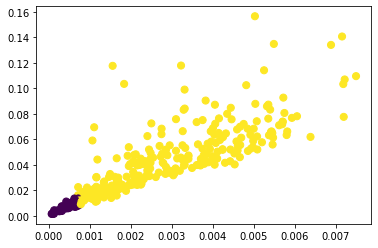

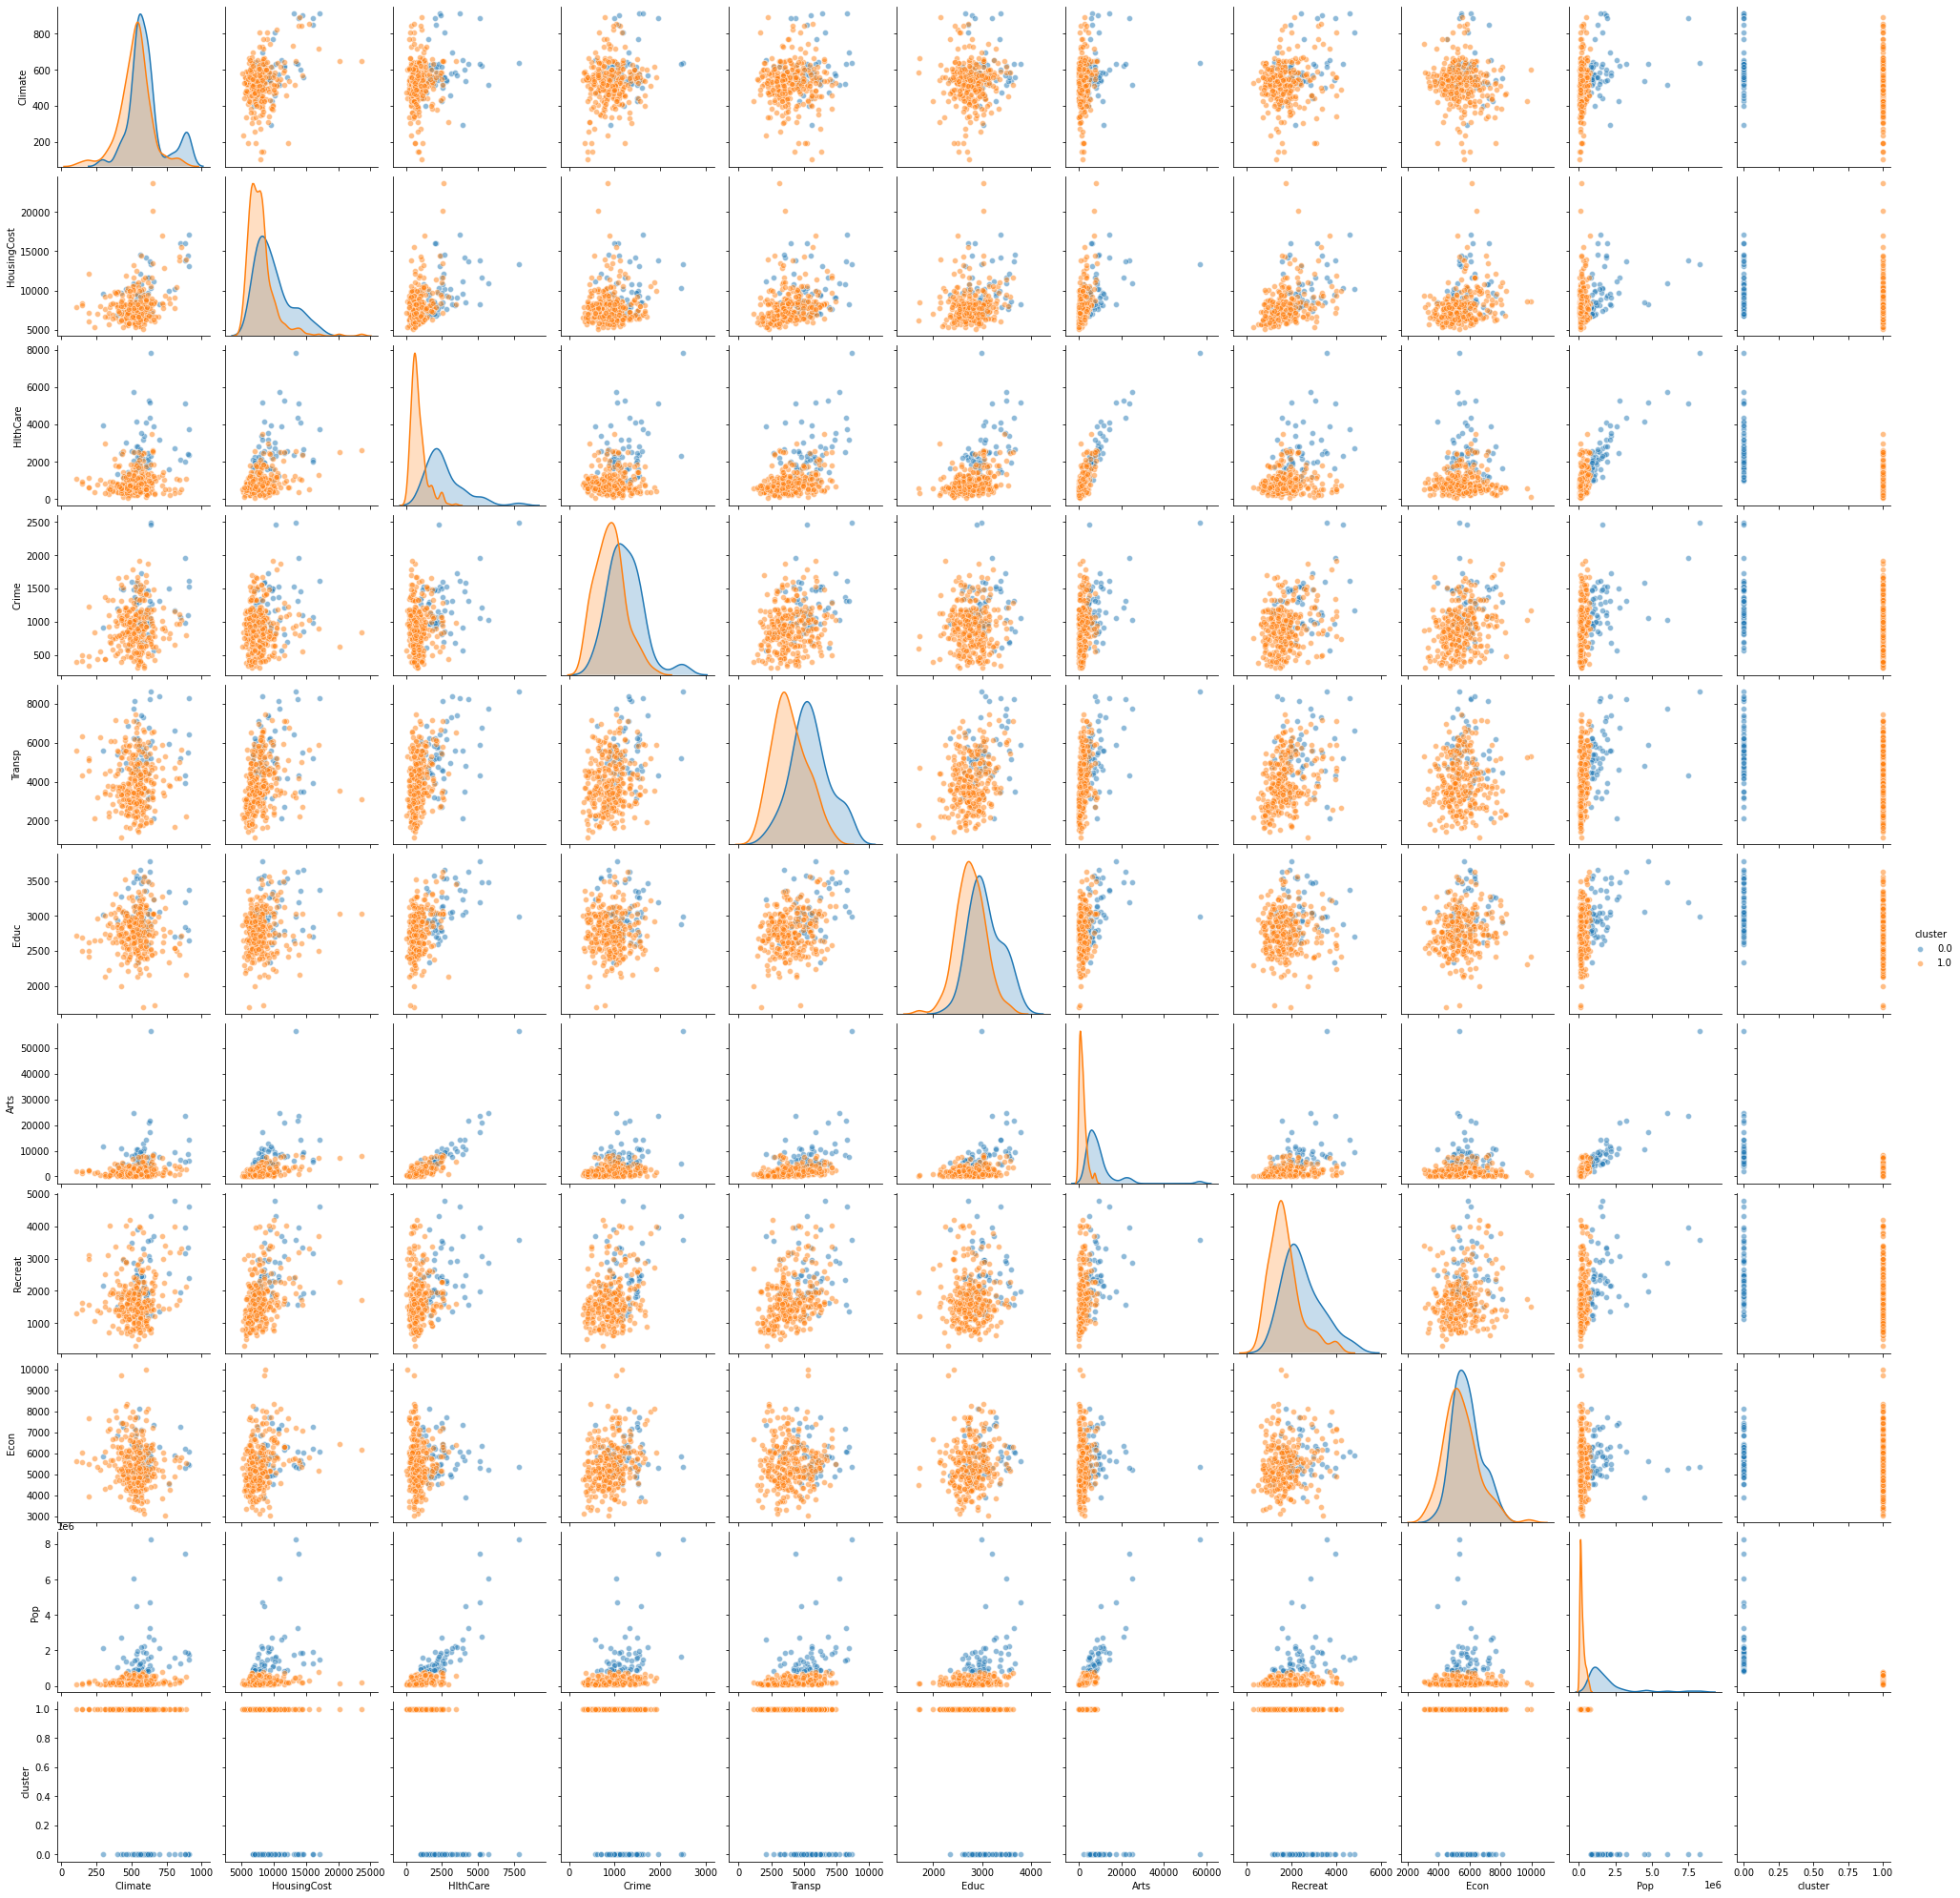

In [68]:
data = pd.read_csv('data.txt', sep=' ')
data.drop(['Place', 'Long', 'Lat'], axis=1, inplace=True) # axis=0 will do for rows
data_pam = data.copy() # shallow copy
data =[list(x) for x in data.to_numpy()]

Z = PAM(k=2)
Z.predict(data)



data_pam['cluster'] = Z.predict(data)
plt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], 
            c = [int(x) for x in data_pam['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
sns.pairplot(data_pam.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':0.5}, 
             vars=data_pam.columns
            )
plt.show()


# Задание 2

В рамках данной лабораторной работы вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [4]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, is_valid_linkage, dendrogram
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

In [261]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

Attribute                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Description
0                       Place                                                                                                                                                                                                                                                                                                                                                                                                                                                         City, state (postal code)
1           Climate & Terrain                                                                                                                                                                                                                                                                                                                             Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days.
2                     Housing                                                                                                                                                                                                                                                                                                                                                                                                                                 Utility bills, property taxes, mortgage payments.
3   Health Care & Environment                                                                                                                                                                                                                                               Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution.
4                       Crime                                                                                                                                                                                                                                                                                                                                                                                                                                          Violent crime rate, property crime rate.
5              Transportation                                                                                                                                                                                                                                                                                                                                                                                   Daily commute, public transportation, Interstate highways, air service, passenger rail service.
6                   Education                                                                                                                                                                                                                                                                                                                                                                       Pupil/teacher ratio in the public K-12 system, effort index in K-12, accademic options in higher education.
7                    The Arts                       

### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [0]:
data = pd.read_csv('data.txt', sep=' ')

<br>  
### Задания: 

&nbsp;&nbsp;&nbsp;0. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.

1. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы.  
<br>  
2. Выполните кластеризацию методом dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
<br>  
3. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
<br>  
4. Выполните кластеризацию методом PAM. Используйте расстояния между объектами, определенные в пункте (1). Определите наилучшее (на ваш взгляд) число кластеров.  
Используйте реализацию алгоритма из Задания 1.  
<br>  
5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
<br>  
6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиения объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
<br>  
7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
<br>  
8. Оцените, как полученные кластеры распределены географически. (Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?

In [10]:
#0 task
data_nec = data.copy()
data_nec.drop(['Place', 'Long', 'Lat'], axis=1, inplace=True) # axis=0 will do for rows

from sklearn import preprocessing
data_nec = pd.DataFrame(preprocessing.normalize(data_nec), columns=list(data_nec.columns))
# Create the Scaler object
scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
scaled_df = scaler.fit_transform(data_nec)
#data_nec = pd.DataFrame(scaled_df, columns=list(data_nec.columns))
data_nec


Climate  HousingCost  HlthCare  ...   Recreat      Econ       Pop
0    0.004673     0.055609  0.002126  ...  0.012602  0.068462  0.994972
1    0.000871     0.012322  0.002507  ...  0.003985  0.006586  0.999820
2    0.004148     0.065044  0.005477  ...  0.007613  0.046530  0.996194
3    0.000569     0.009459  0.001712  ...  0.001934  0.007014  0.999869
4    0.001569     0.019987  0.004413  ...  0.006220  0.013638  0.999465
..        ...          ...       ...  ...       ...       ...       ...
324  0.001394     0.021621  0.004478  ...  0.002258  0.012504  0.999589
325  0.003096     0.037273  0.001835  ...  0.012386  0.028858  0.998430
326  0.001416     0.021948  0.001869  ...  0.002208  0.012968  0.999619
327  0.001073     0.013211  0.002064  ...  0.002497  0.007327  0.999829
328  0.005934     0.076853  0.002069  ...  0.008959  0.045809  0.995223

[329 rows x 10 columns]

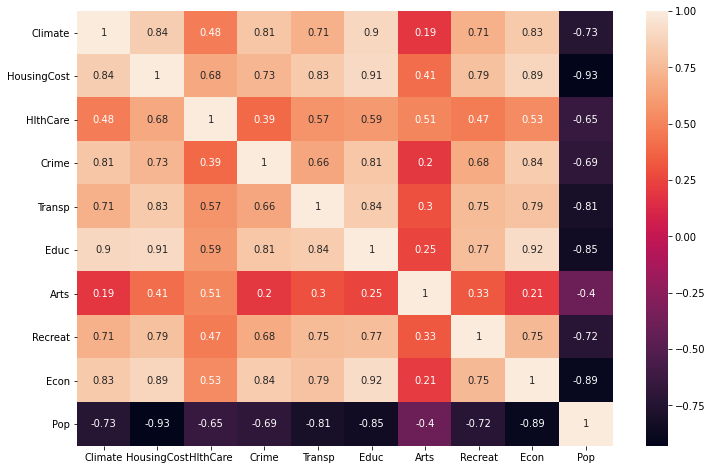

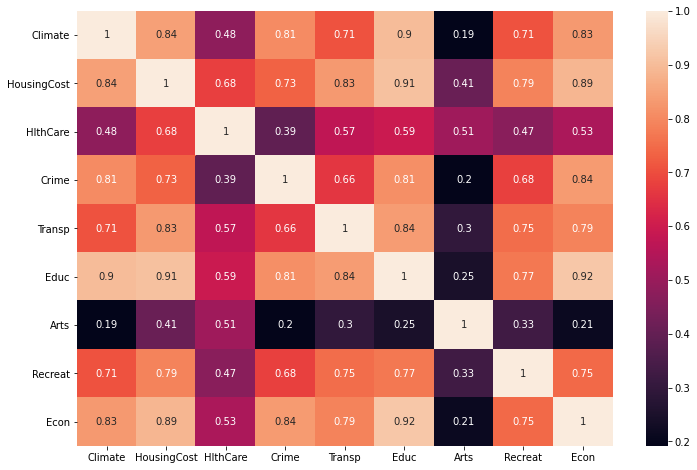

'\nтак то лучше\n'

In [17]:
#describe
#data_nec.plot(kind="bar",subplots=True,layout=(4,3),sharey=False,figsize=(15, 15))
#plt.show()
D_corr =data_nec.corr().loc[data_nec.columns,
                      data_nec.columns
                     ]
plt.figure(figsize=(12, 8))
sns.heatmap(D_corr, annot=True)
plt.show()
'''
как видно по матрице корреляции столбец с популяцией стоит тоже удалить 
так как он слишком сильно влияет на остальные (и по сравнению с другими даже
после нормализации слишком большой)
'''
data_nec.drop(['Pop'], axis=1, inplace=True) # axis=0 will do for rows
D_corr =data_nec.corr().loc[data_nec.columns,
                      data_nec.columns
                     ]
plt.figure(figsize=(12, 8))
sns.heatmap(D_corr, annot=True)
plt.show()
'''
так то лучше
'''

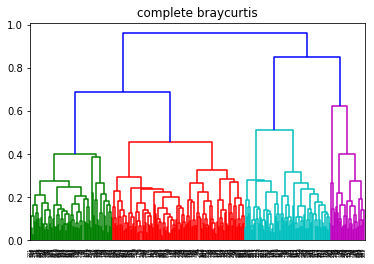

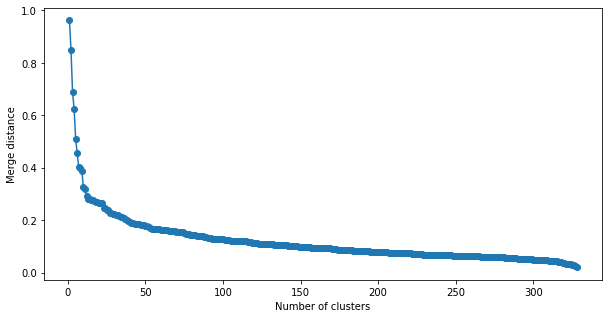

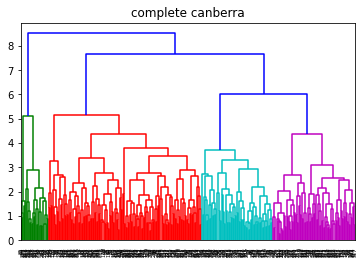

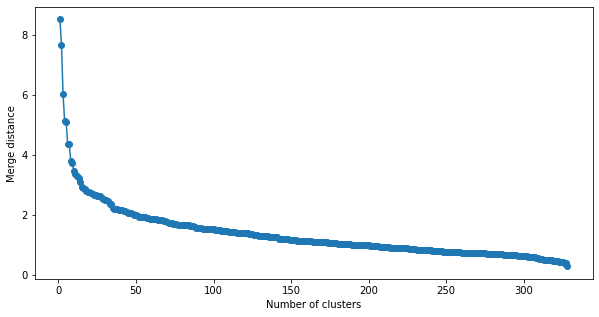

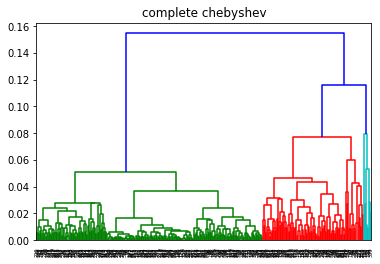

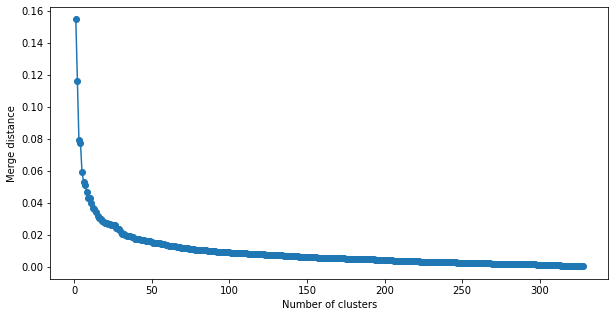

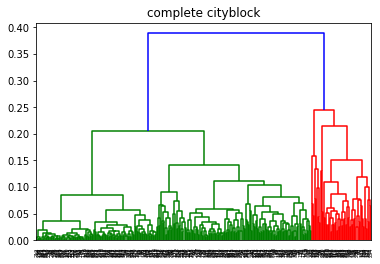

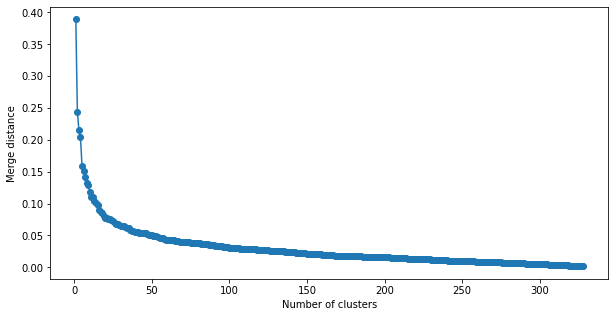

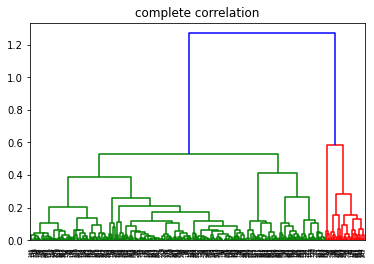

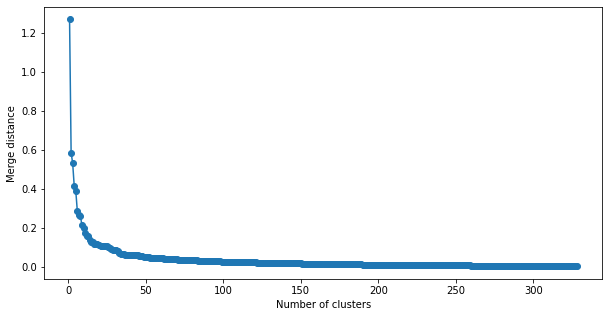

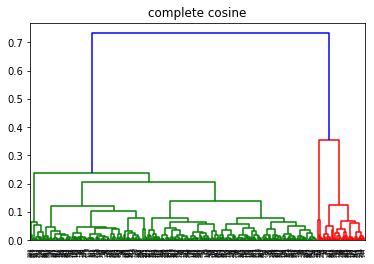

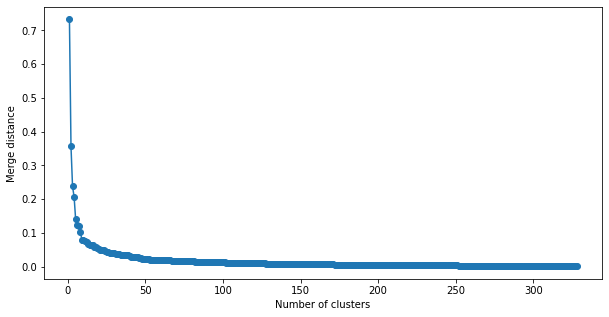

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


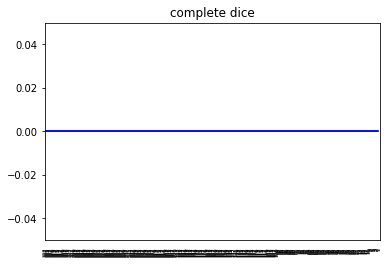

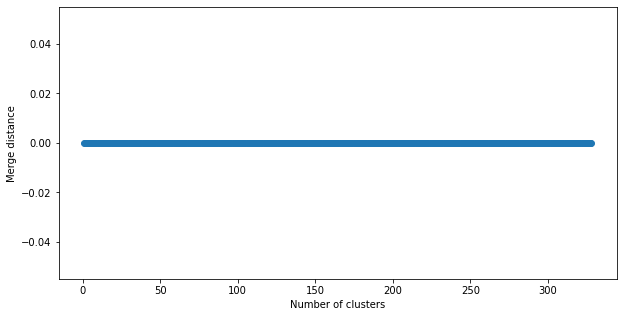

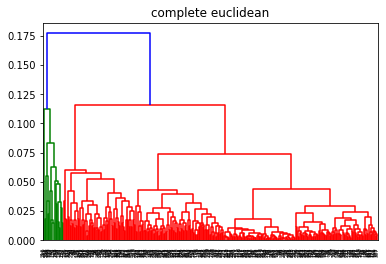

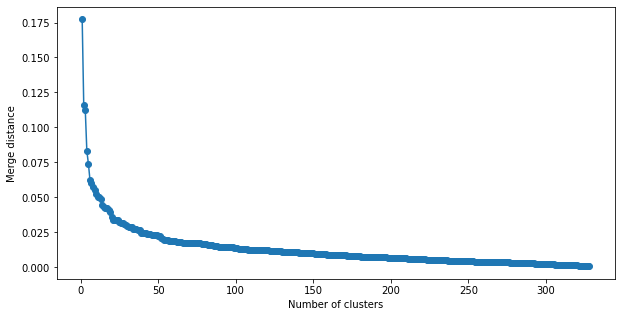

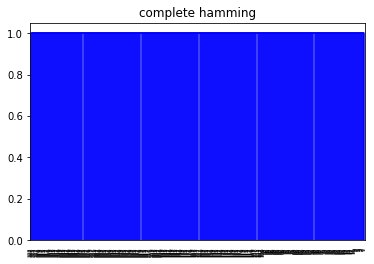

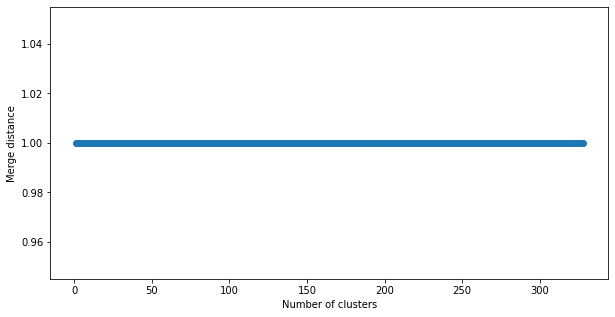

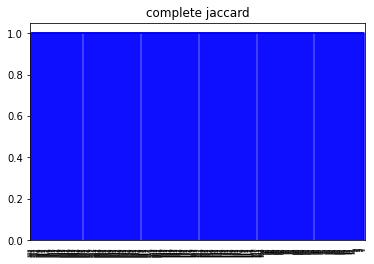

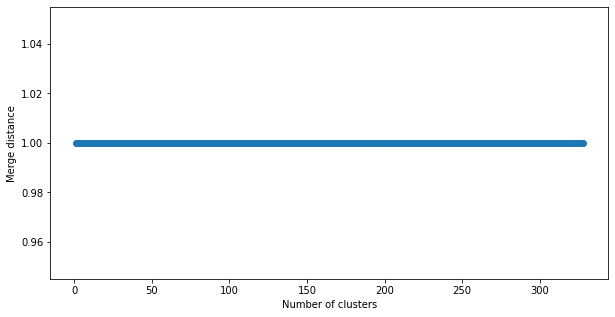

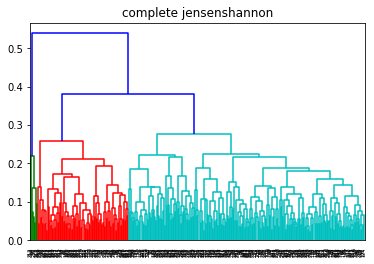

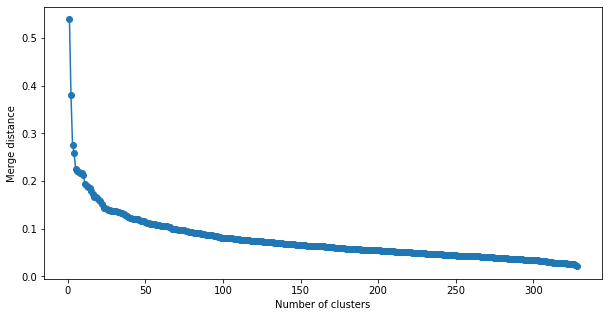

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


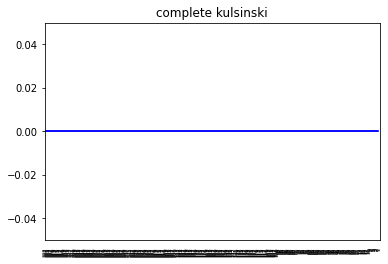

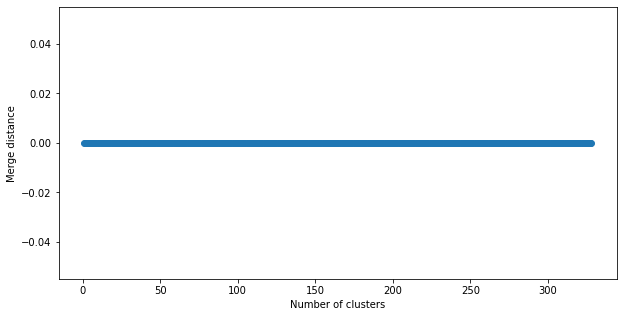

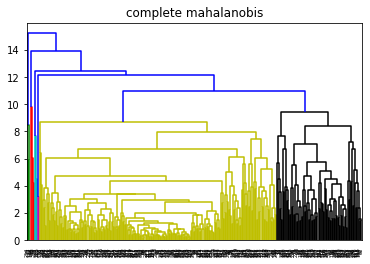

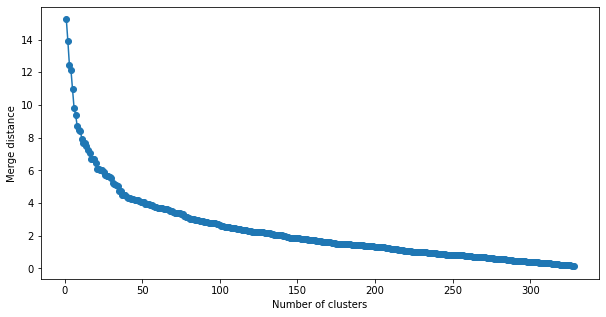

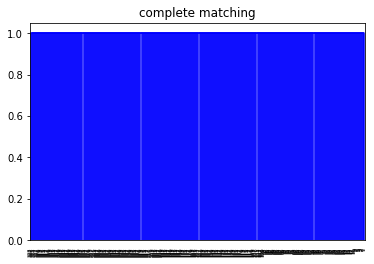

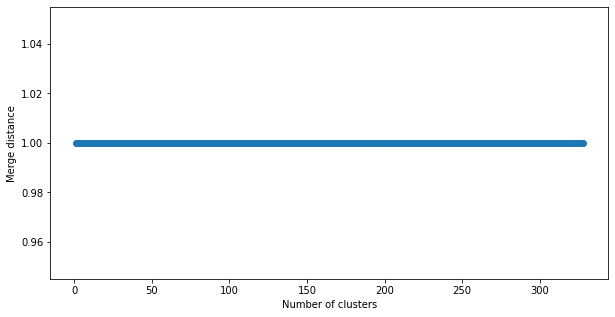

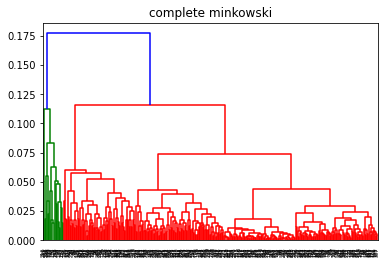

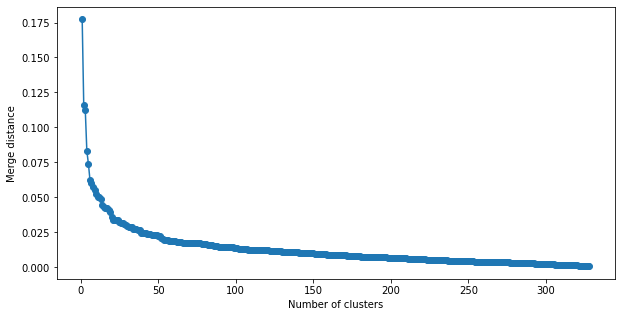

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


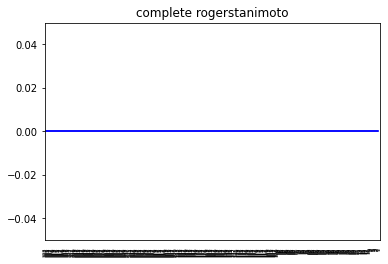

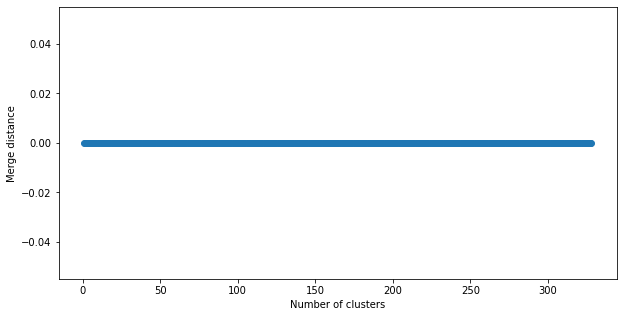

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


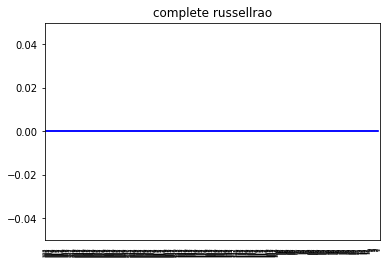

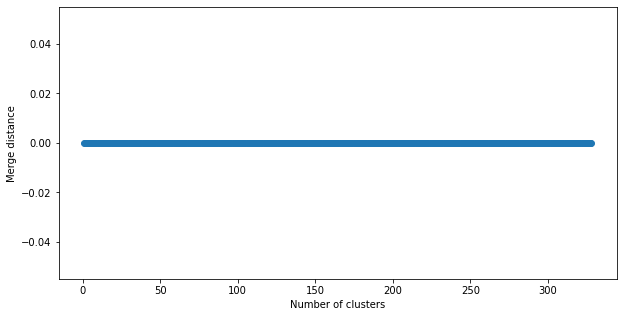

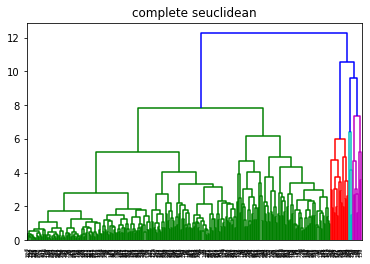

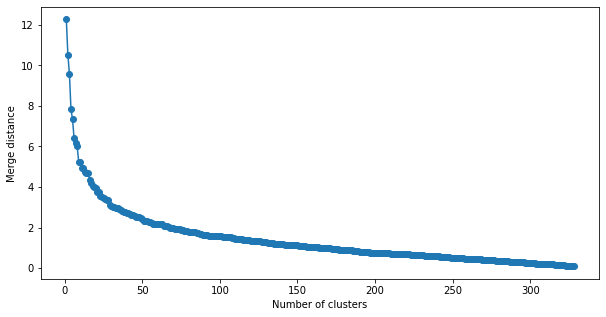

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


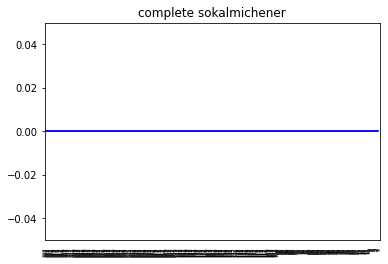

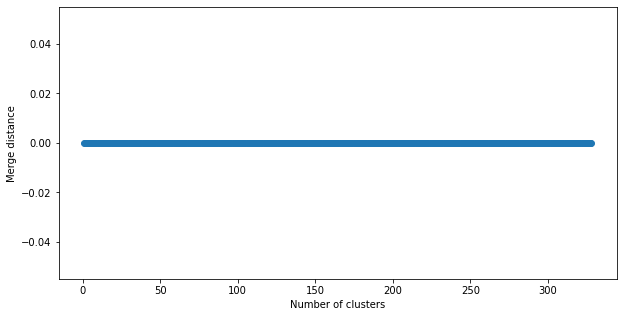

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


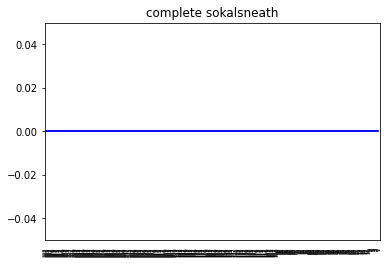

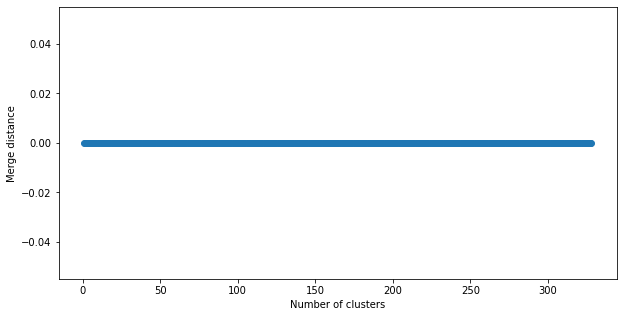

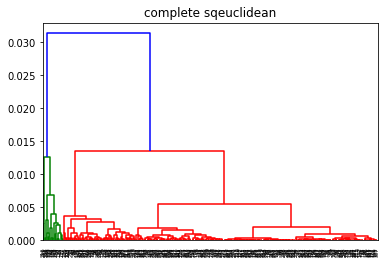

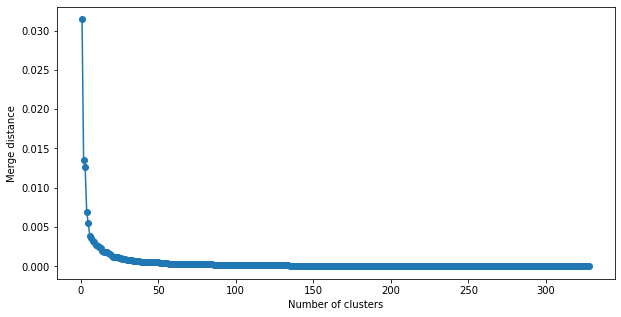

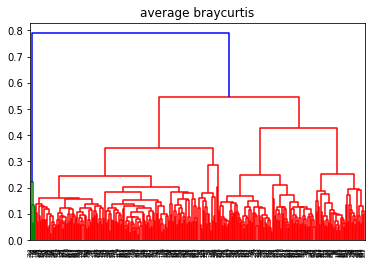

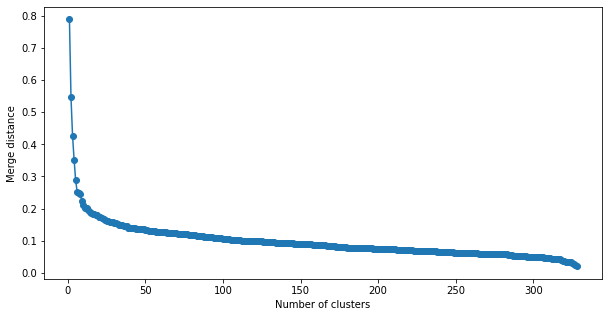

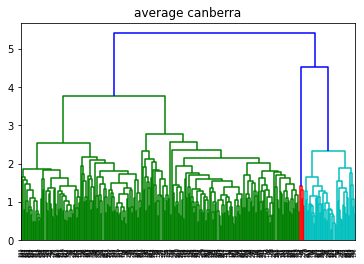

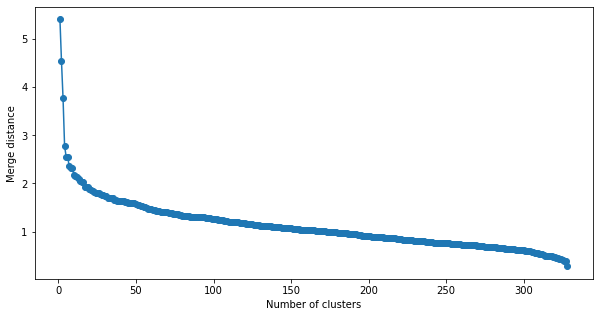

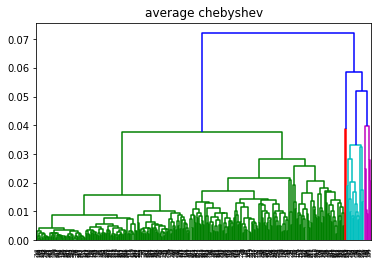

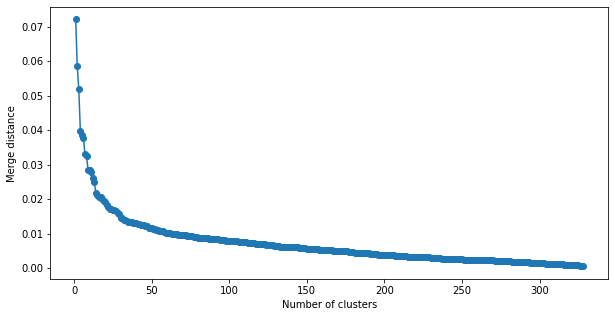

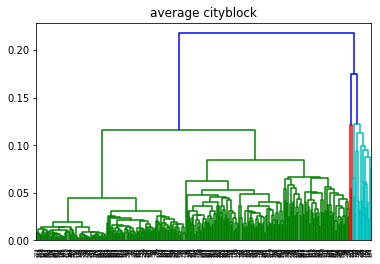

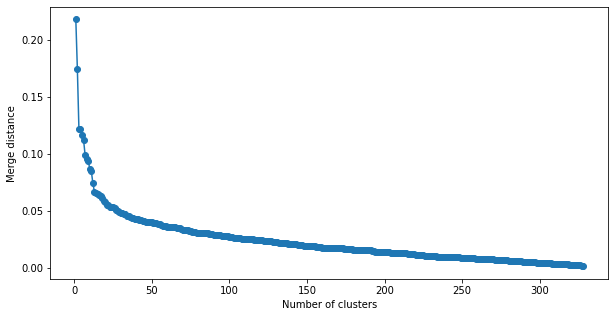

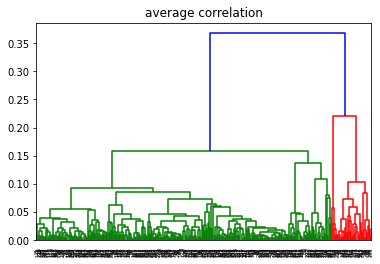

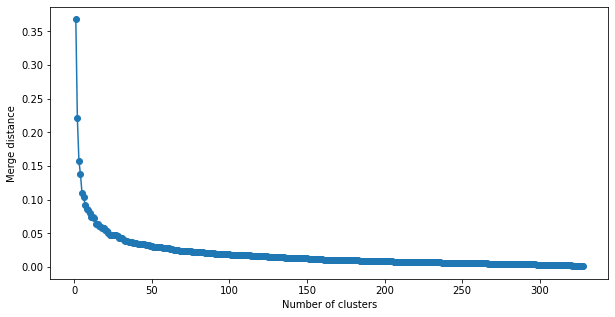

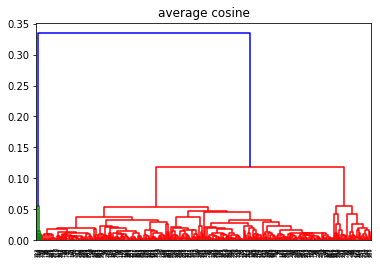

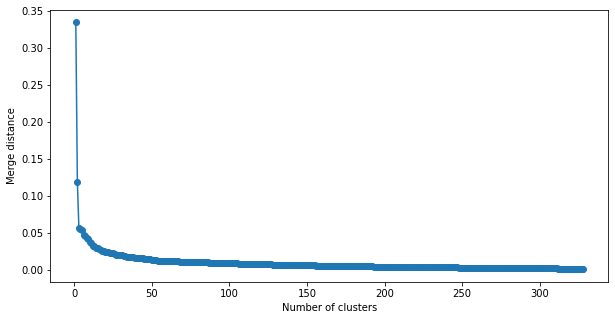

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


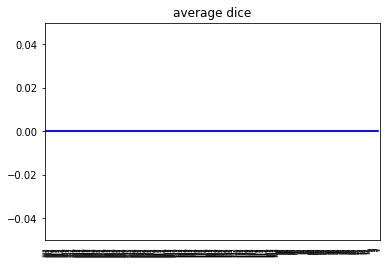

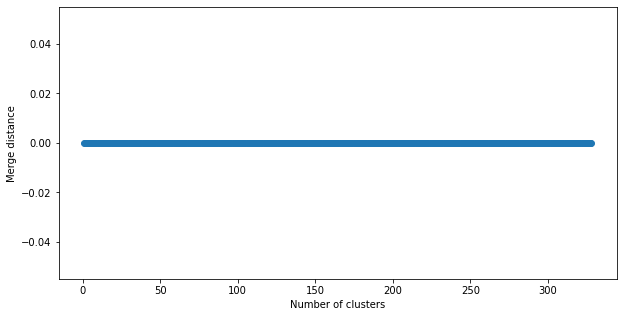

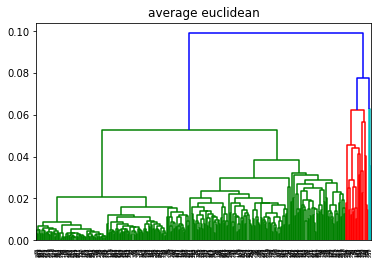

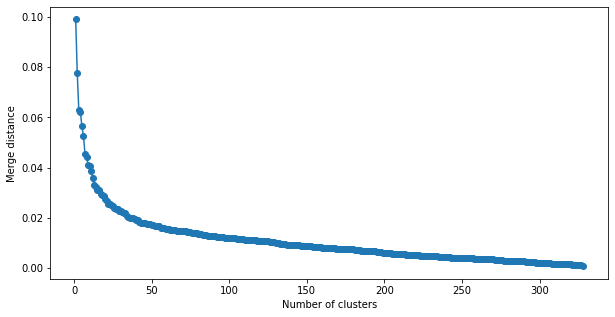

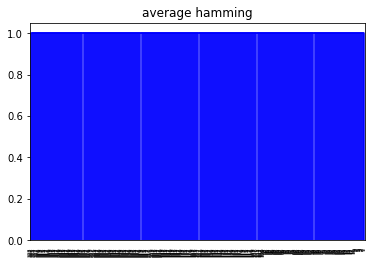

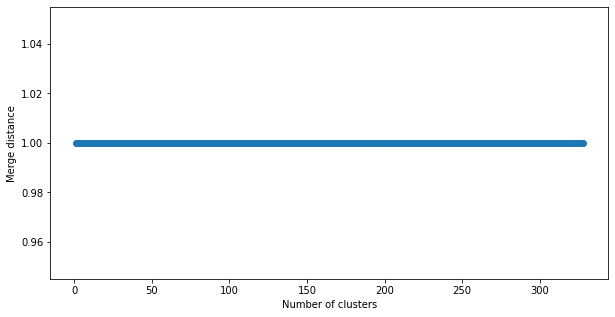

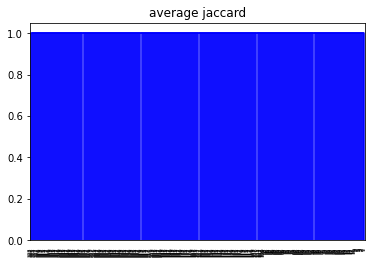

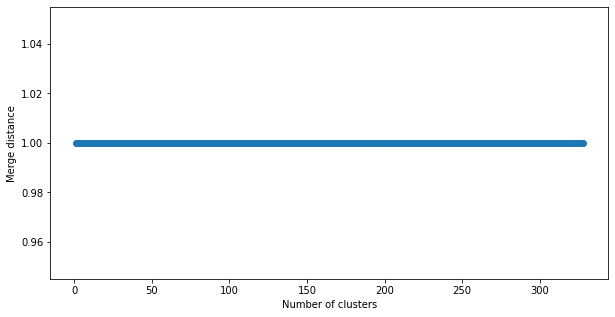

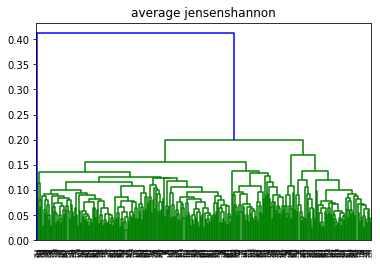

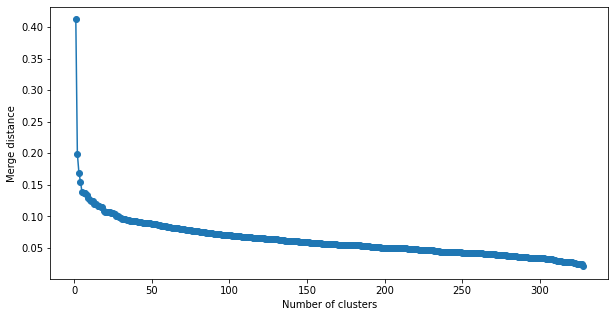

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


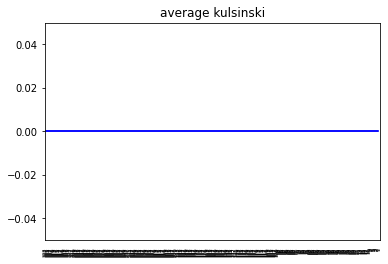

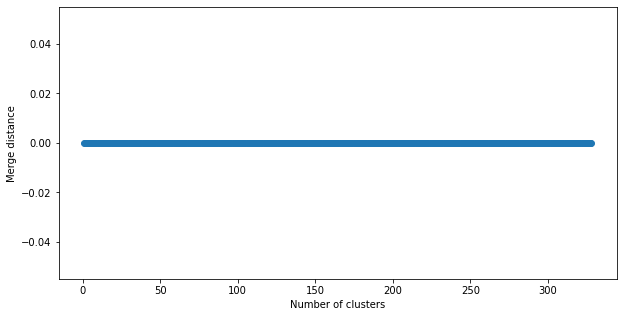

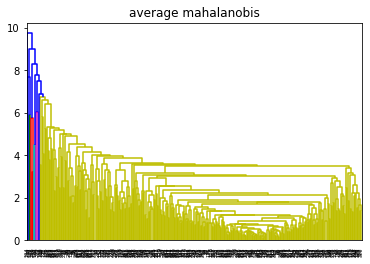

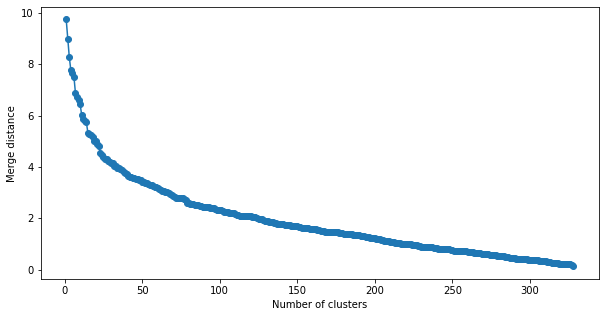

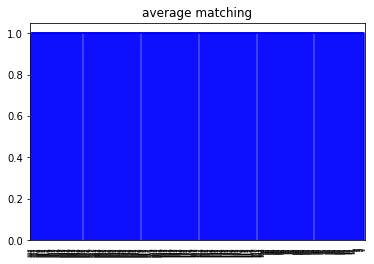

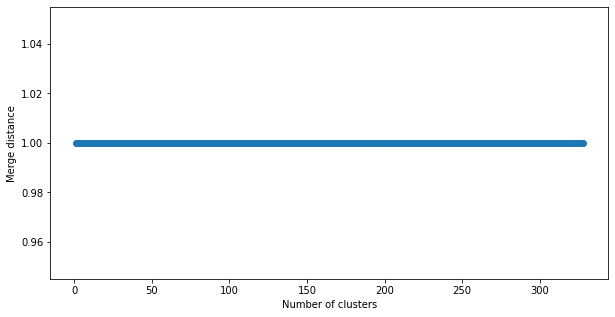

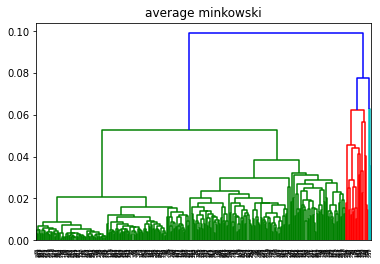

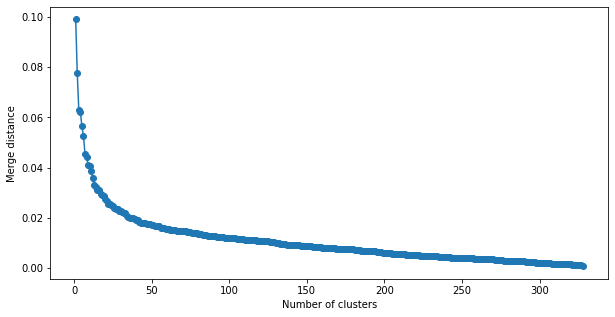

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


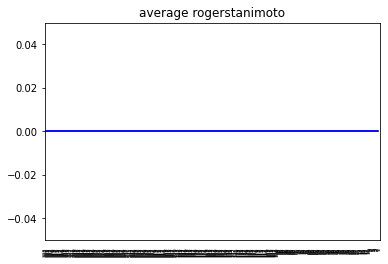

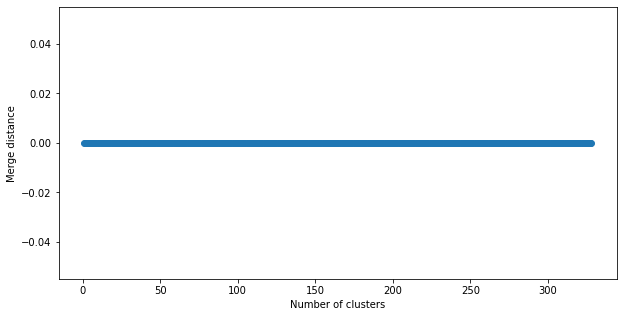

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


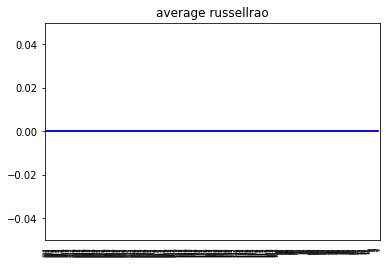

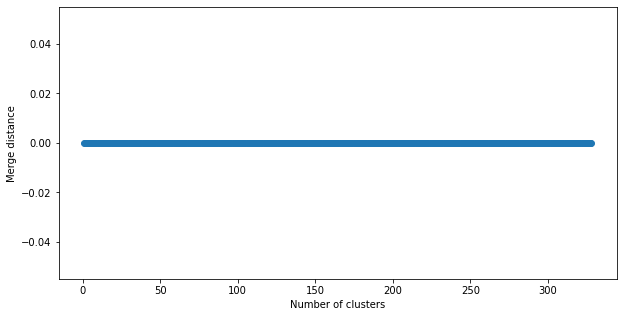

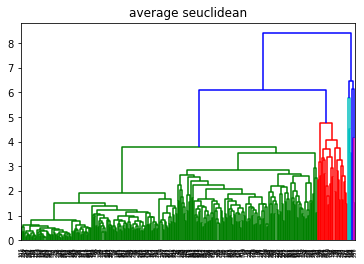

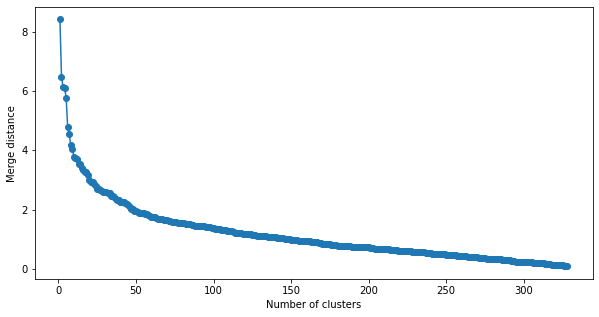

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


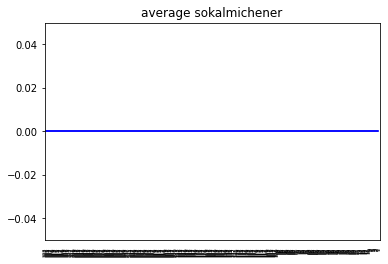

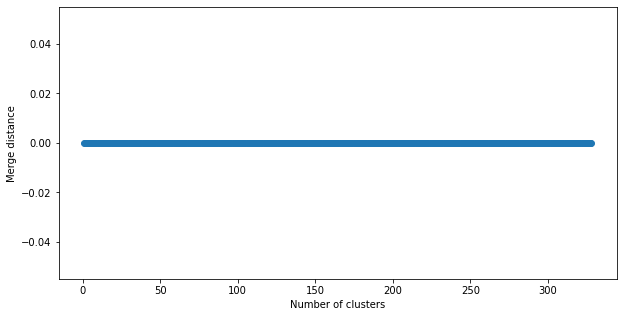

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


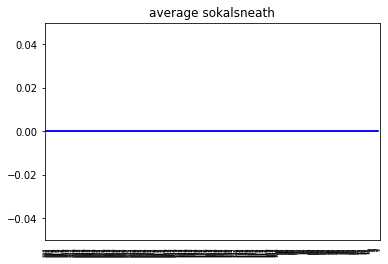

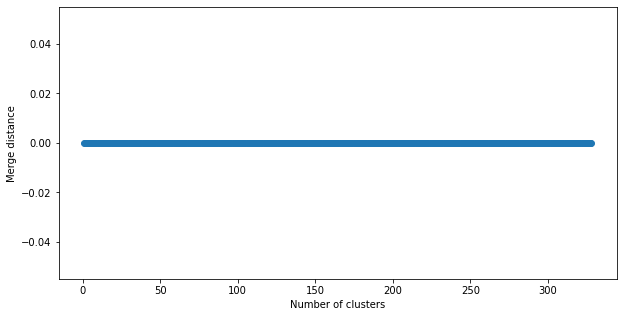

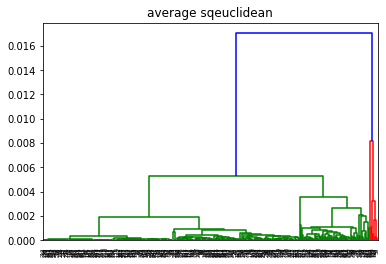

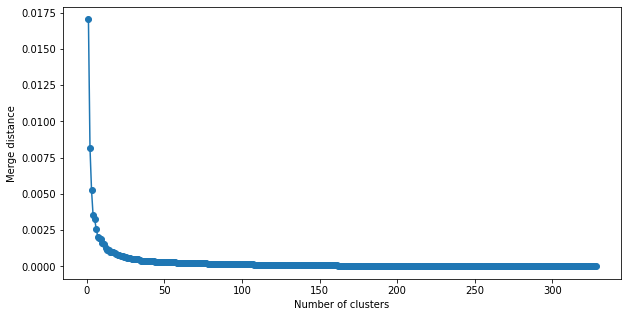

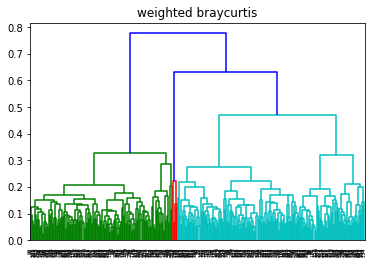

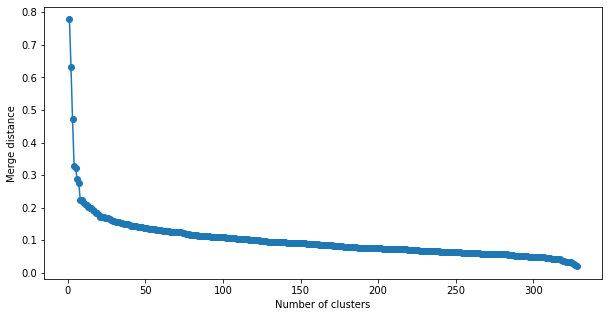

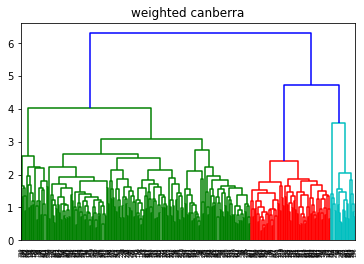

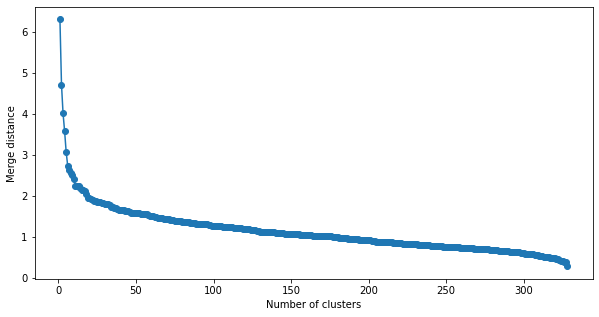

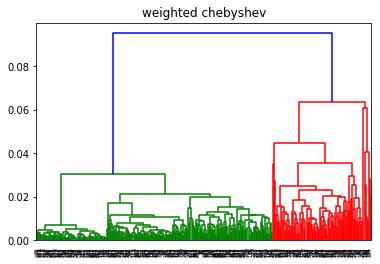

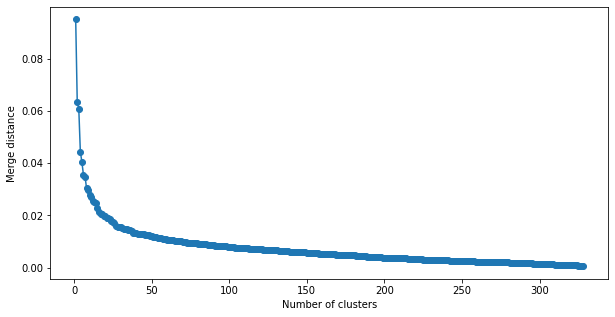

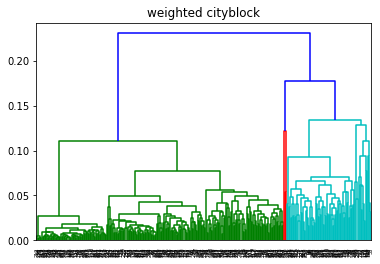

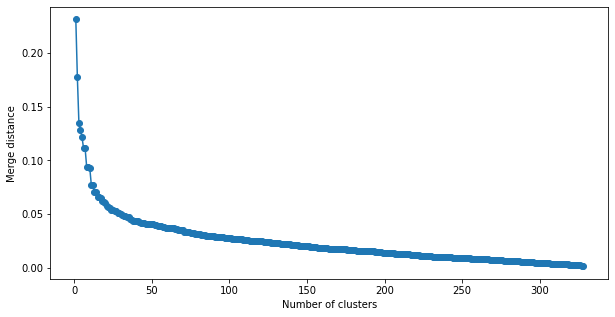

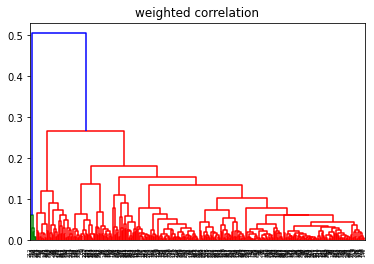

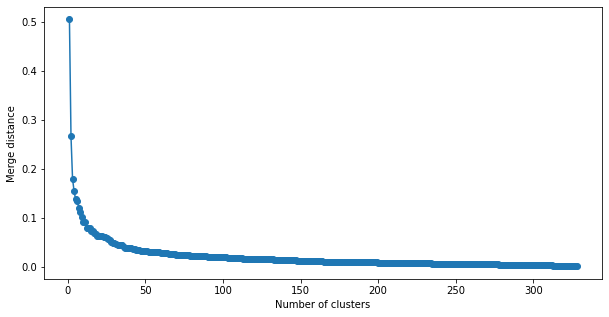

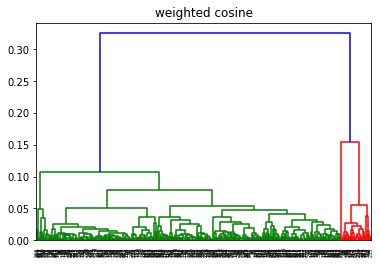

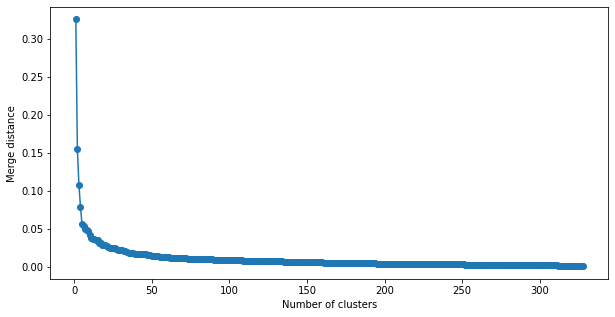

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


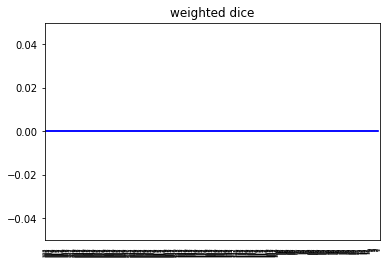

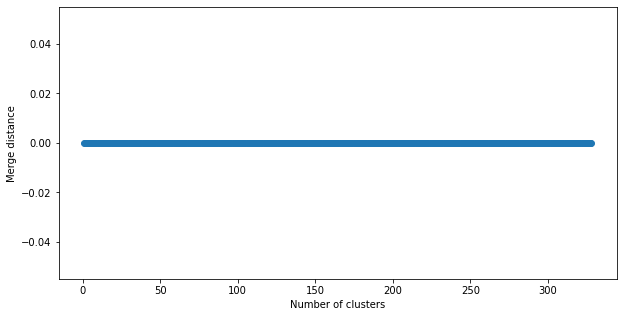

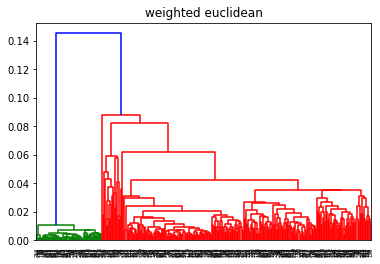

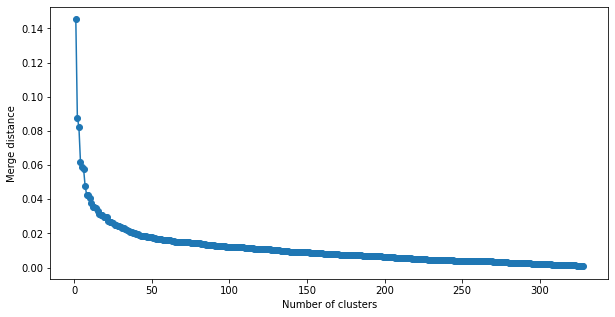

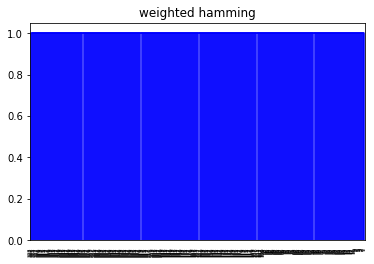

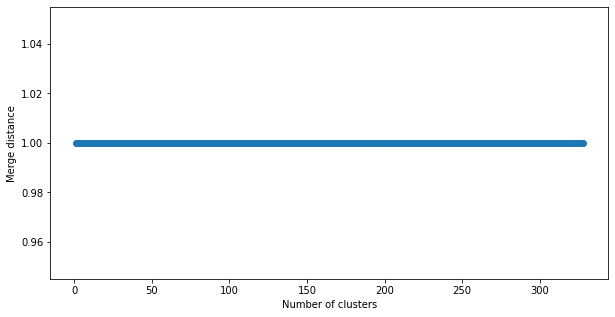

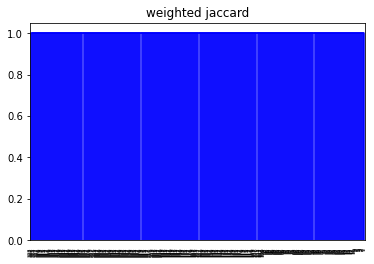

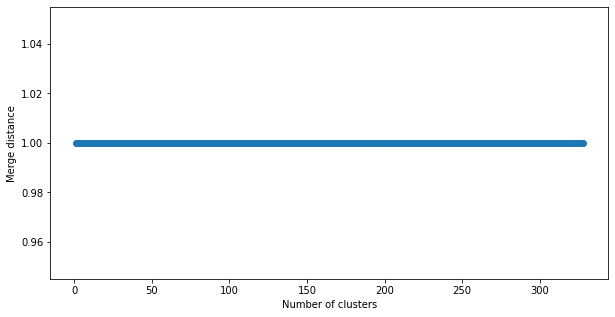

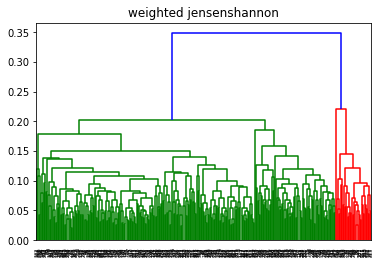

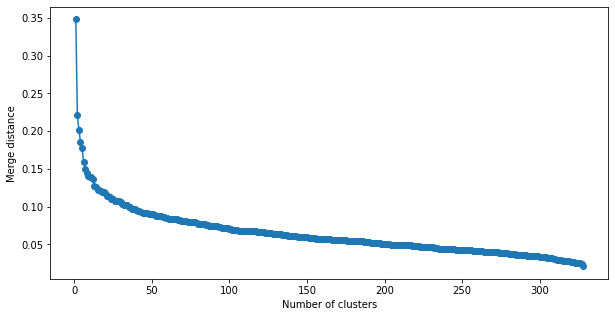

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


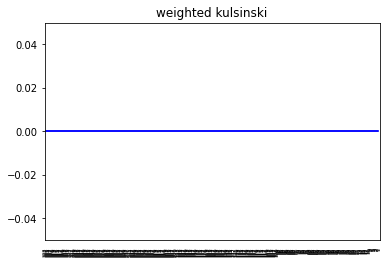

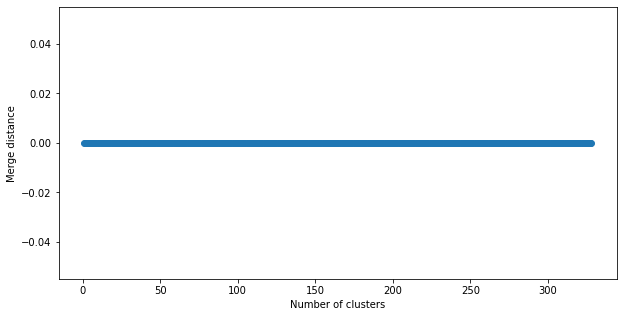

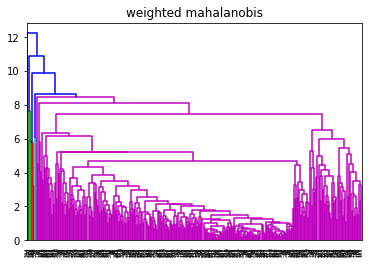

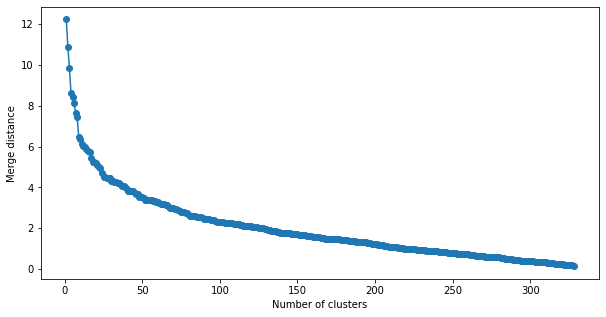

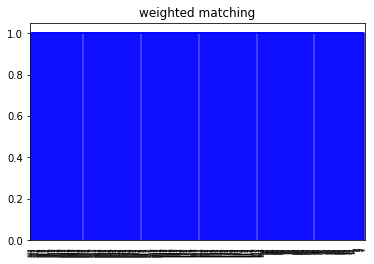

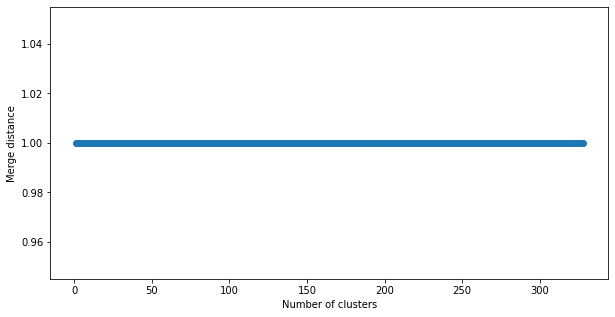

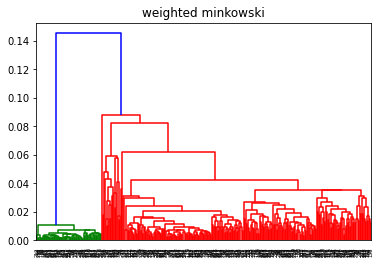

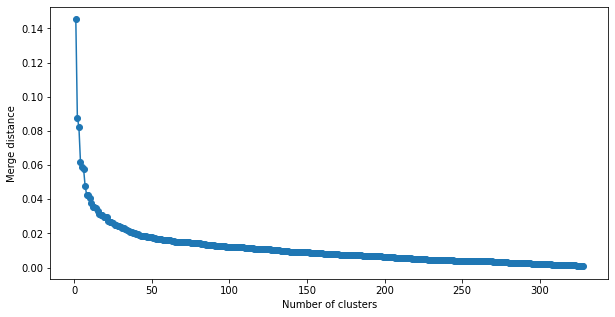

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


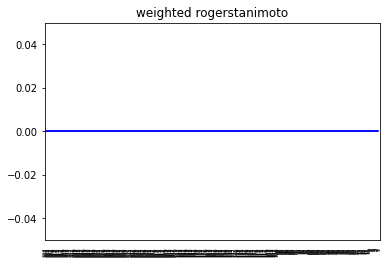

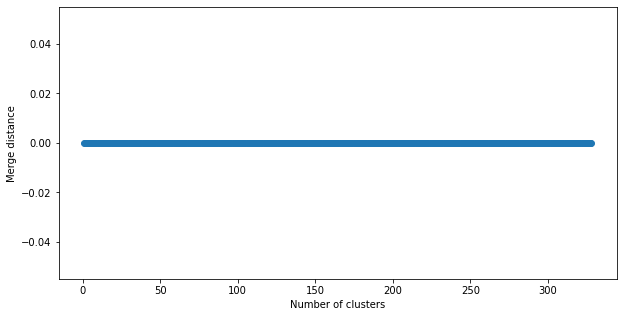

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


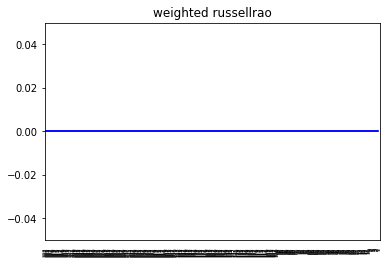

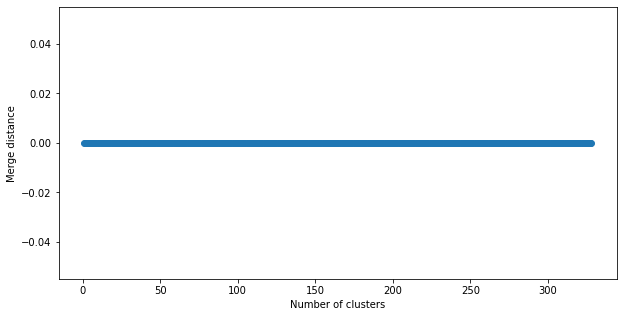

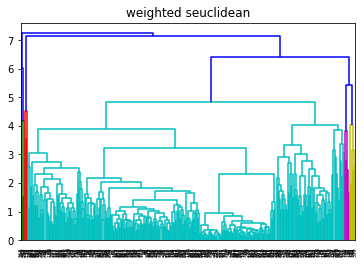

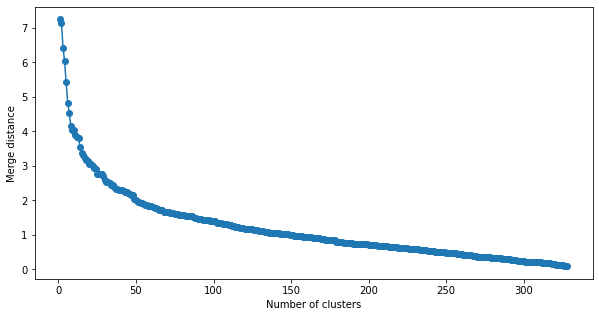

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


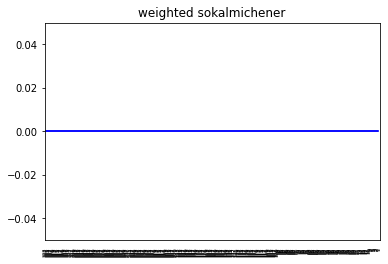

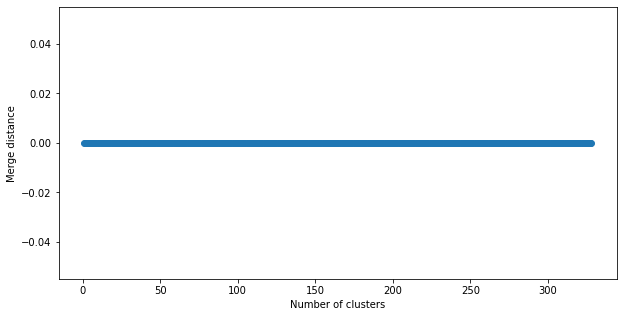

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


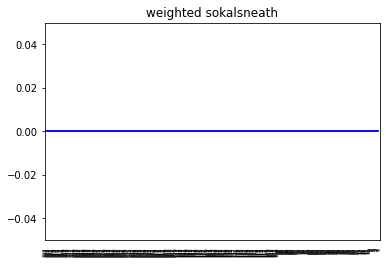

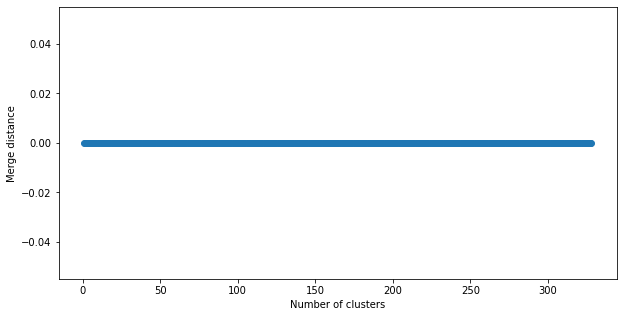

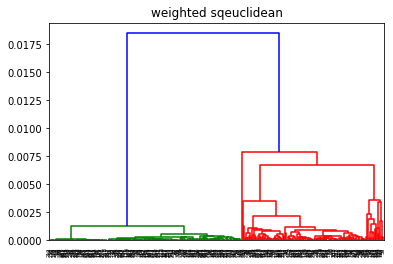

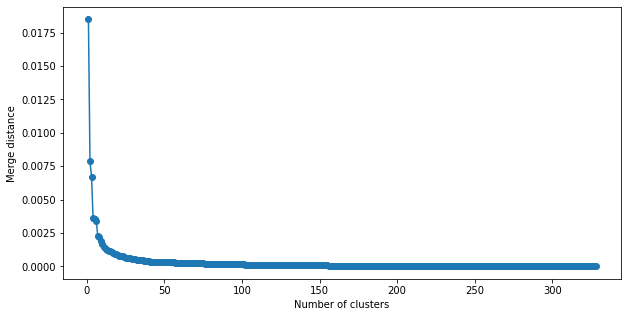

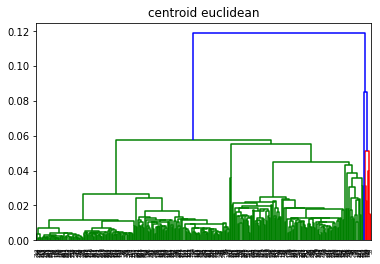

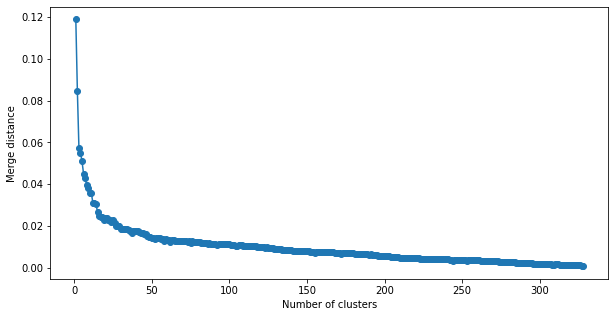

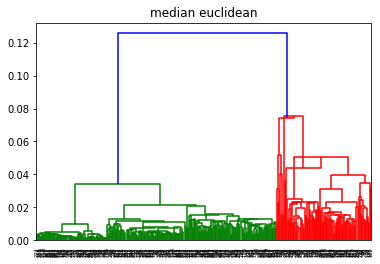

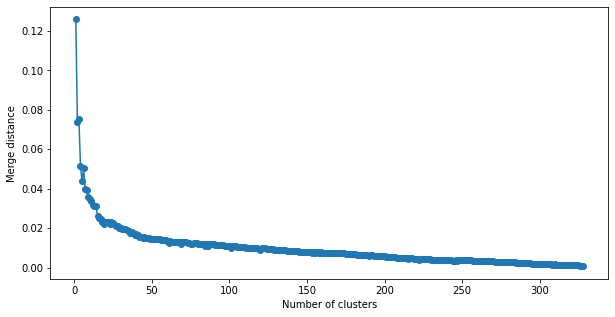

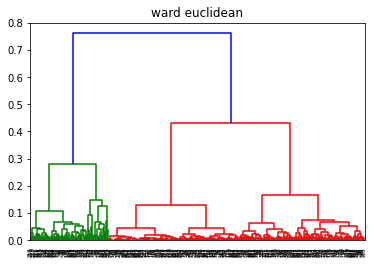

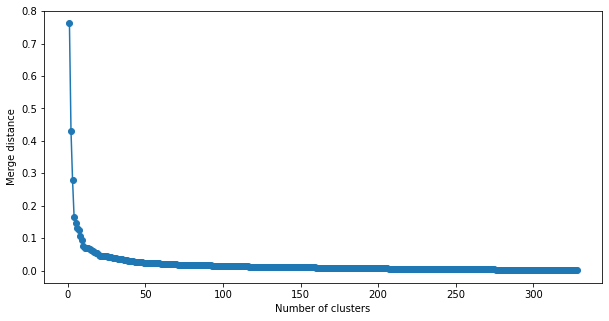

'\n\nВывод: наиболее оптимальная комбинация complete minkowski с перегибов в локтевом \nграфике в 0.4 \nВизуально на графике много ответвлений и они довольно плоские, из чего \nя сделала вывод что на основании определенных признаков делалась резкая кластеризация\n'

In [298]:
'''
не включать, очень долгая функция
'''
def ierarxy(method, metric):
  Z = linkage(data_nec, method=method, metric=metric)
  plt.title(method + " " + metric)
  dendrogram(Z)
  plt.show()
  return Z

def plot_elbow(Z, h=10, w=5):
    plt.figure(figsize=(h, w))
    plt.plot(np.array(range(1, np.shape(Z)[0]+1)), 
             Z[:,2][::-1], 
             marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Merge distance")
    plt.show()
methods = ['complete', 'average', 'weighted']
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 
           'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 
           'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 
           'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 
           'sqeuclidean']

for i in methods:
  for j in metrics:
   plot_elbow(ierarxy(i, j))

methods = [ 'centroid', 'median', 'ward']
for i in methods:
    plot_elbow(ierarxy(i, 'euclidean'))
'''
данный код перебираетвсе возможные комбинации методов и метрик и строит по ним график отображающий
разбиение и локтевой график отобращающий зависимость количества кластеров от растояний до ближайших 
соседей

изучив данные я пришла к выводу что количество кластеров должно быть в диапозоне от 4 до 6
то есть дешевые дома в трущебах, дома в спальнх районах (так же плохие, средние и хорошие), 
дома в дорогих районах (так же плохие, средние и хорошие)
выбирая метрики я смотрела на локтевые графики, чтобы до перегиба было не слишком много точек (хотя 
бы меньше 10)

некоторые коммбинации давали прямую линию вместо локтя, их я очевидно рассматривать не буду

такой результат мне давала только метрика cosine, которая рассмотривает данные как вектора
но мне важно чтобы дом с параметрами 0,0,0,... не был в одной категории с домом 1,1,1,...

тогда я понизила свои требования и решила брать параметр разбиения до самого локтя, но
локтевой график должен более крутой, чтобы разбиение присходило в начале, а не в самом конце 
при маленьки расстояниях

остановимся на методе complete так как он визуально раскидывает классы более адекватно чем остальные
и рассмотрим формулы метрик, помня, что дома нельзя рассматривать как вектора

метрика jensenshannon основана на вероятностных распределениях, выглядит не так симпатично как не которые 
другие, но зато не основана на векторах)
'''

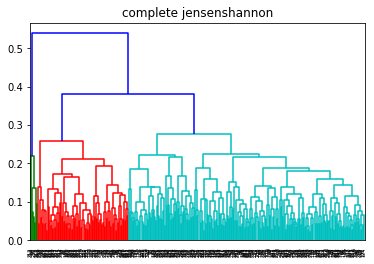

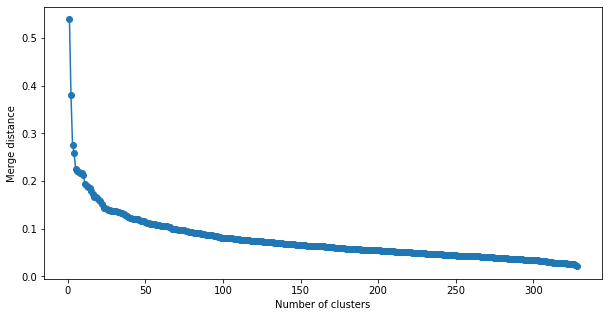

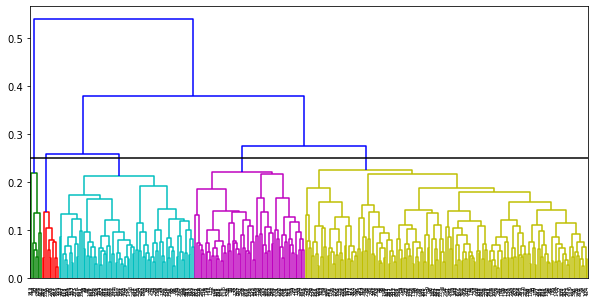

In [28]:
'''
выведем понравившеюся нам метрику еще раз и рассмотрим параметр перешиба равный
0.25 вычисленный по локтевому графику
у нас получается 5 классов, которые разные по размерам, но я думаю это входит в 
рамки нормы, мы же не знаем какой у нас дата сет. в полне возможно что элитных дома там 2
'''
def ierarxy(method, metric):
  Z = linkage(data_nec, method=method, metric=metric)
  plt.title(method + " " + metric)
  dendrogram(Z)
  plt.show()
  return Z

def plot_elbow(Z, h=10, w=5):
    plt.figure(figsize=(h, w))
    plt.plot(np.array(range(1, np.shape(Z)[0]+1)), 
             Z[:,2][::-1], 
             marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Merge distance")
    plt.show()
Z = ierarxy('complete', 'jensenshannon')
plot_elbow(Z)
plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0.25)
plt.axhline(y=0.25, c='k')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


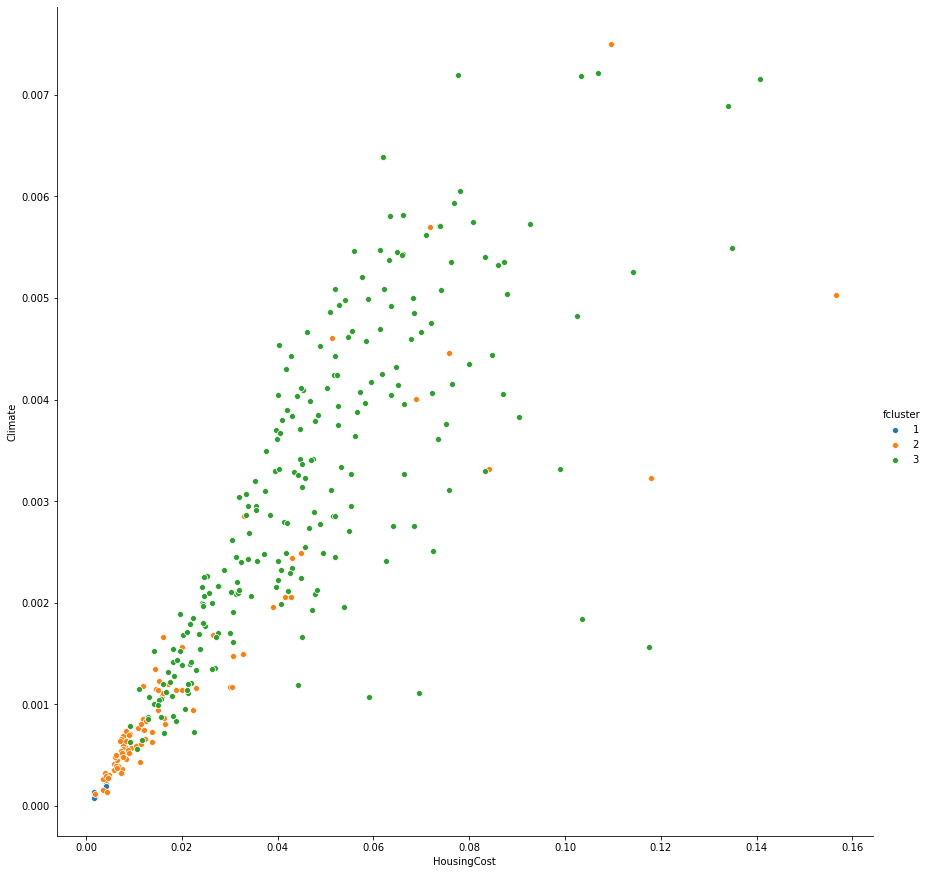

In [36]:
data_nec['fcluster'] = fcluster(Z, t=3, criterion='maxclust')

sns.pairplot(x_vars="HousingCost", 
             y_vars="Climate", 
             hue='fcluster',
             data=data_nec, 
             size=12)
plt.show()
data_nec.drop(['fcluster'], axis=1, inplace=True) # axis=0 will do for rows

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


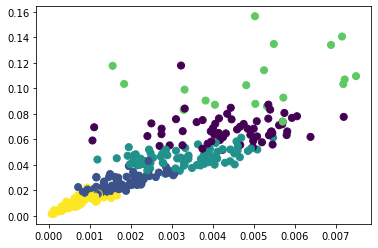

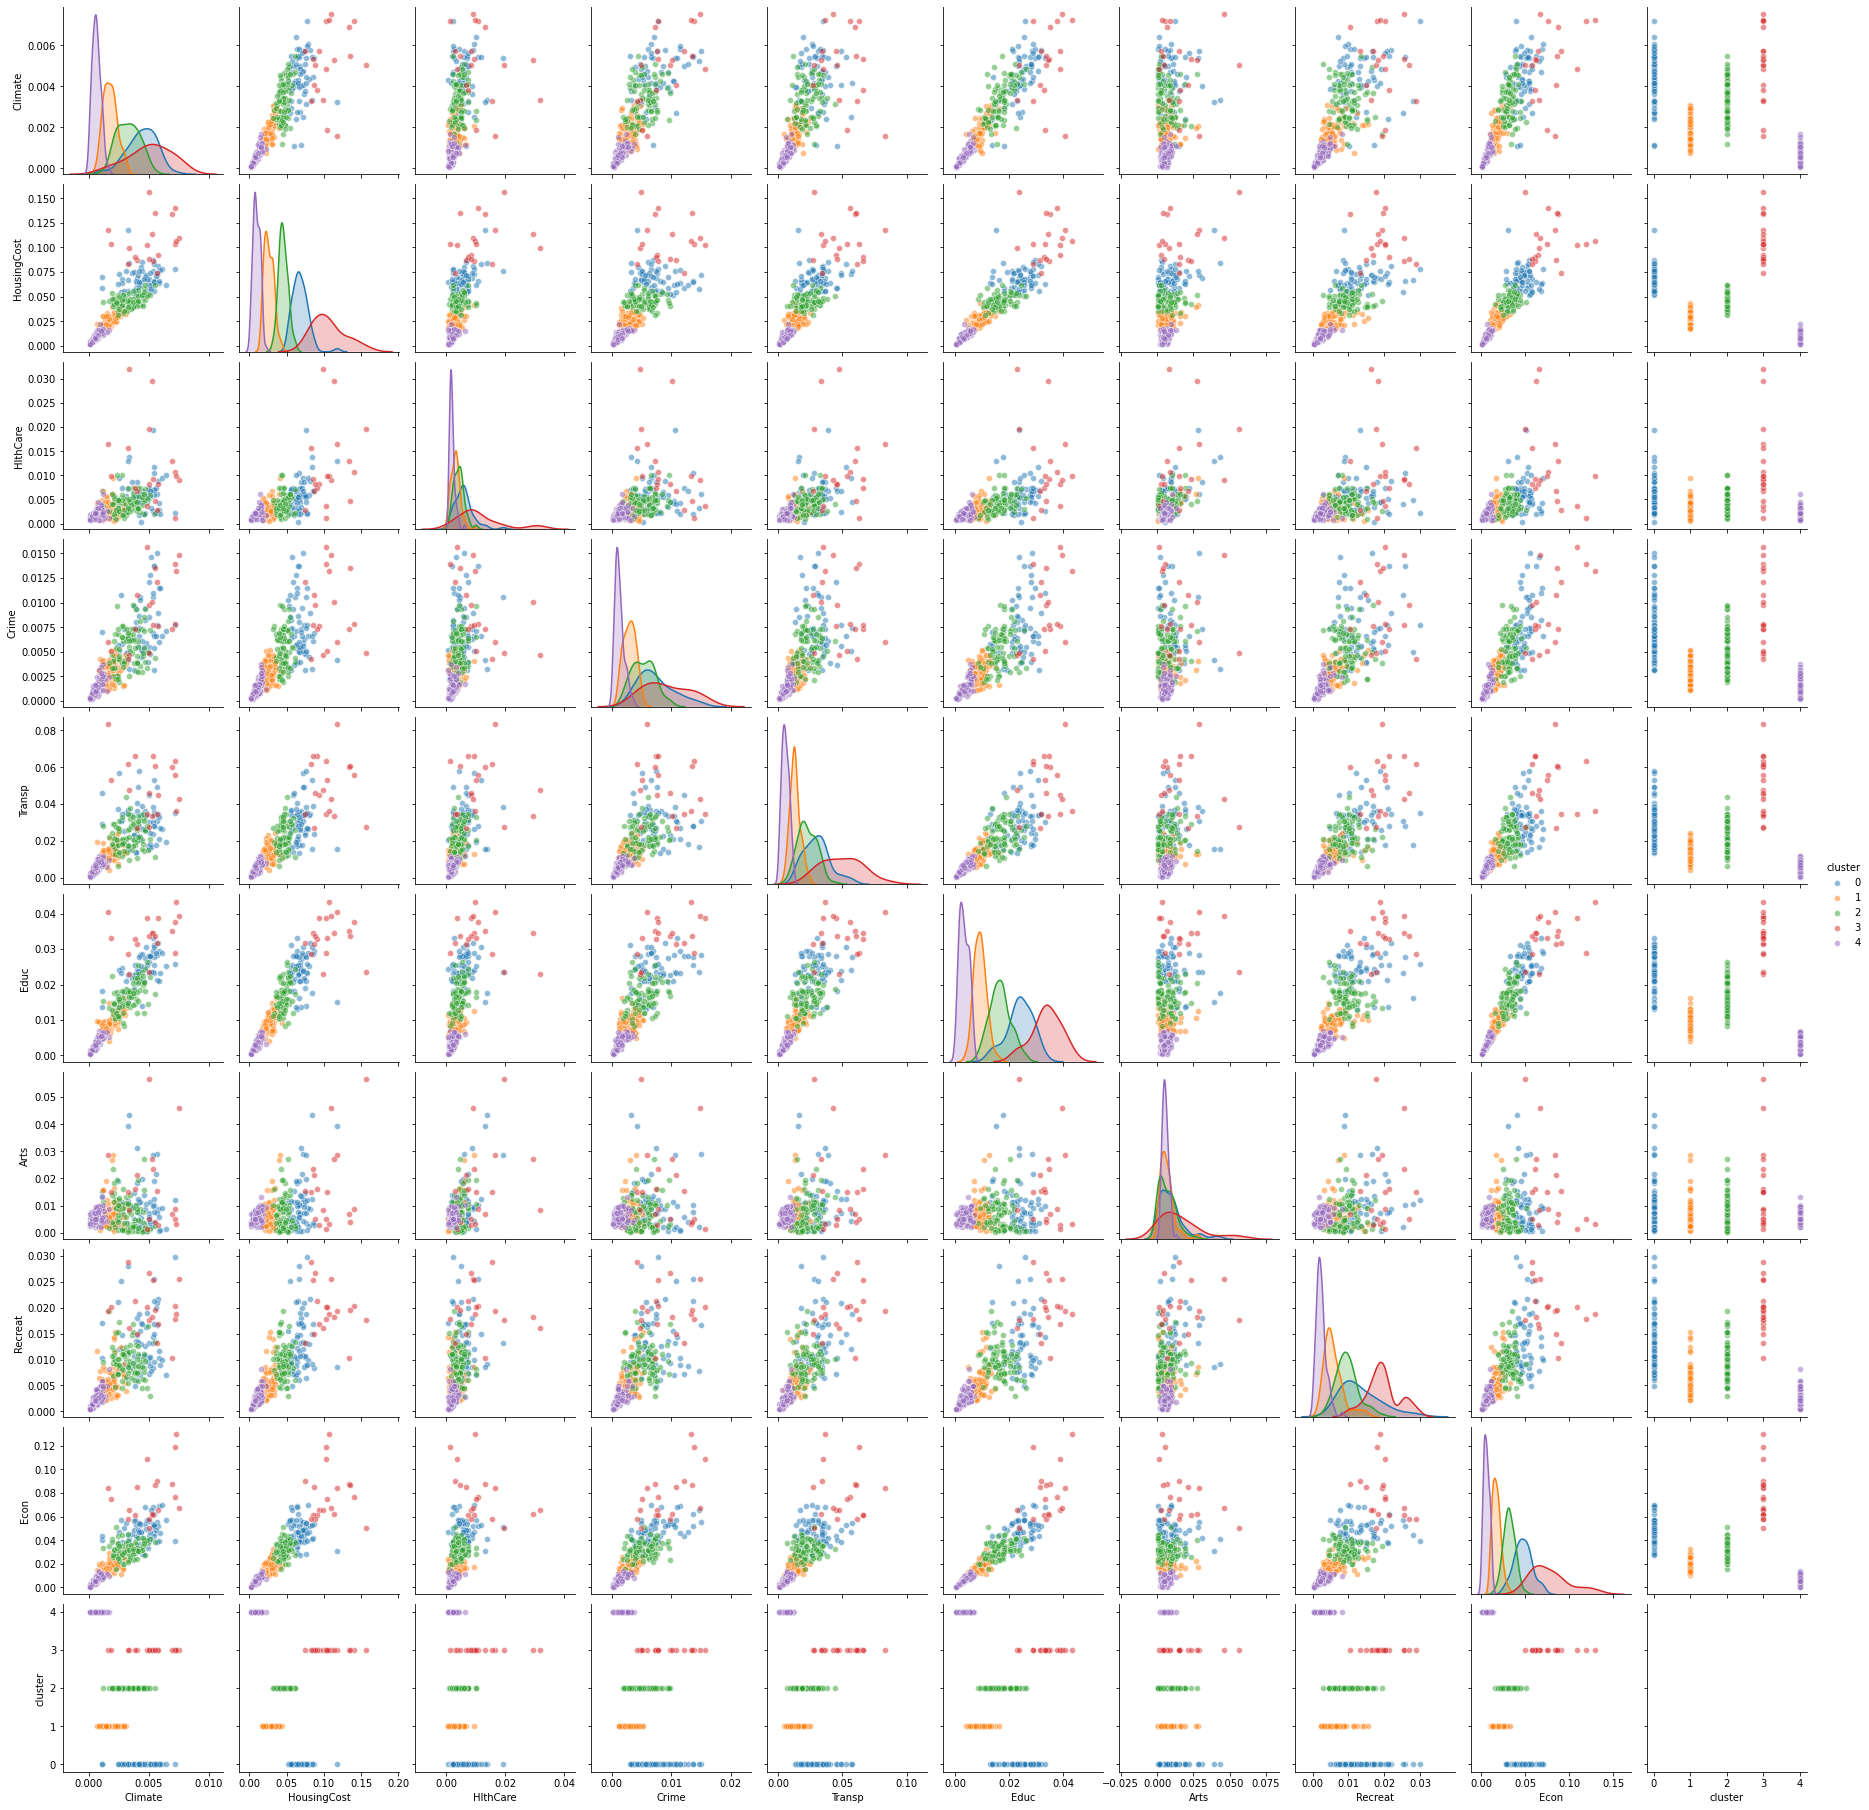

In [86]:
#task 4
Z = KMeans(n_clusters = 5, # число кластеров
           init = 'random',
           n_init = 1,
           max_iter = 100, 
           random_state=15434,
          )
Z.fit(data_nec)
data_kmeans = data_nec.copy() # shallow copy

data_kmeans['cluster'] = Z.labels_.astype(str)
plt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], 
            c = [int(x) for x in data_kmeans['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
sns.pairplot(data_kmeans.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':0.5}, 
             vars=data_kmeans.columns
            )
plt.show()



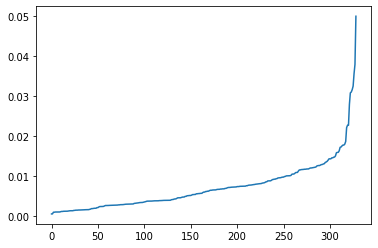

In [25]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_nec)
distances, indices = nbrs.kneighbors(data_nec)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

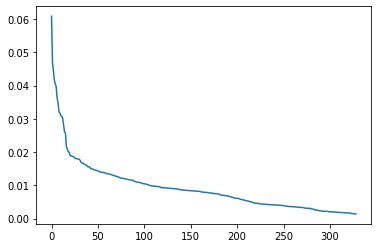

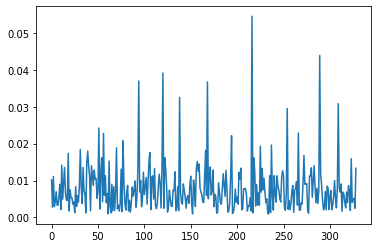

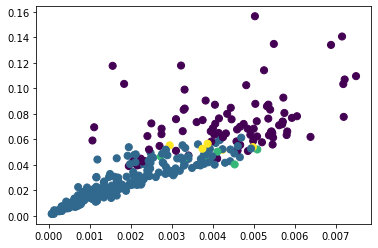

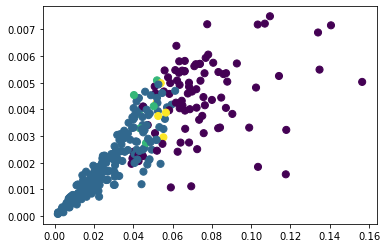

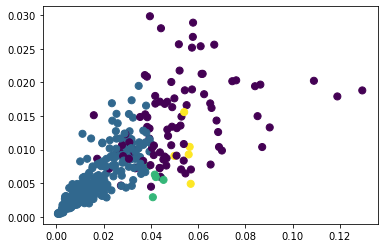

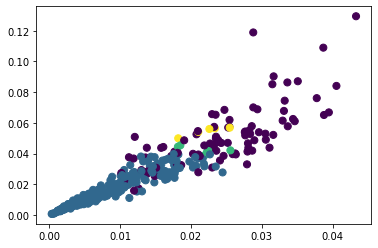

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


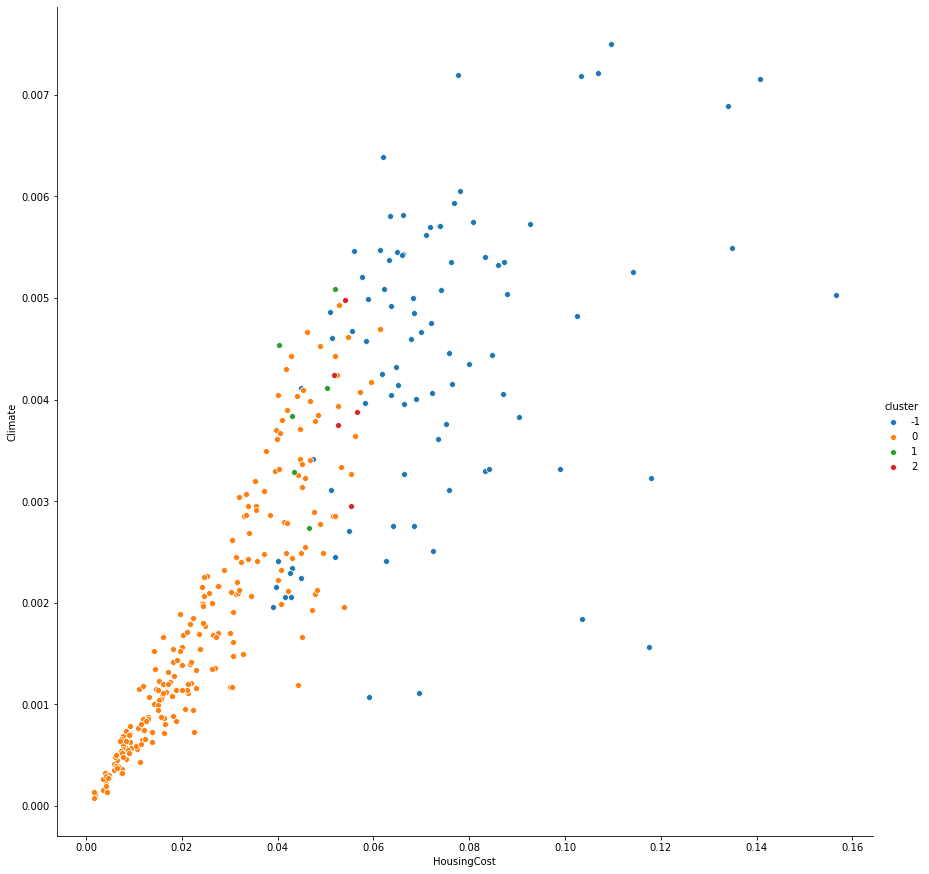

In [24]:
# 2 task
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
import scipy


dbscan = DBSCAN(eps=0.01, min_samples=k, metric='euclidean')
dbscan.fit_predict(data_nec)
#print(X_embedded)
#plt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], c = X_embedded, s = 50, cmap = 'viridis')
#plt.figure(figsize=(12, 12))
data_db = data_nec.copy() # shallow copy

data_db['cluster'] = dbscan.labels_.astype(str)
plt.scatter(data_nec.to_numpy()[:, 0], data_nec.to_numpy()[:, 1], 
            c = [int(x) for x in data_db['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
plt.show()
plt.scatter(data_nec['HousingCost'].values.tolist(), 
            data_nec['Climate'].values.tolist(), 
            c = [int(x) for x in data_db['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
plt.show()
plt.scatter(data_nec['Econ'].values.tolist(), 
            data_nec['Recreat'].values.tolist(), 
            c = [int(x) for x in data_db['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
plt.show()
plt.scatter(data_nec['Educ'].values.tolist(), 
            data_nec['Econ'].values.tolist(), 
            c = [int(x) for x in data_db['cluster'].to_numpy()], 
            s = 50, cmap = 'viridis')
plt.show()
sns.pairplot(x_vars="HousingCost", 
             y_vars="Climate", 
             hue='cluster',
             data=data_db, 
             size=12)
plt.show()       
plt.show()


In [26]:
#describing 
from sklearn import metrics

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


algorithms = []
algorithms.append(KMeans(n_clusters=5, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=5, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=5))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'Silhouette': metrics.silhouette_score(data_nec.to_numpy(), algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

ValueError: ignored